# **APPENDIX A** - Data Preparation



# Table of contents
1. [Introduction](#introduction)
2. [Data Filtering](#paragraph1)
3. [Outlier Analysis](#paragraph2)
4. [Complementing Data](#paragraph3)
5. [Data Bias](#paragraph4)


### Introduction

The data provided records all the listings on ImmoScout from 2004 to 2015. Since platform users entered these listings manually, they contain many incorrect and missing values.
All codes in this annex can offer additional insights into the data, given that they include interactive graphs and maps. The most useful interactive visualizations can be found under the “Quick Access” folder in [this thesis’s GitHub repository](https://github.com/Alex11212121/Bachelor_Thesis/tree/main/Quick%20Access). Several adjustments have been made to allow a pdf export of this documentation; these will be mentioned accordingly. Additionally, this jupyter notebook is a **documentation of the code** used for this thesis, the actual script used to the analysis can be found under the “Raw Code” folder in [this thesis’s GitHub repository](https://github.com/Alex11212121/Bachelor_Thesis/tree/main/Raw%20Code%20Annex%201).

In [1]:
#checking required packages are installed. Uncomment to run.

"""
!pip install -U kaleido 
!pip install -U folium
!pip install -U matplotlib
!pip install -U numpy
!pip install -U pandas
!pip install -U plotly
!pip install -U seaborn
!pip install -U scikit-learn
!pip install -U scipy
!pip install -U statsmodels
!pip install -U Pillow
!pip install -U notebook-as-pdf
!pip install -U tqdm
"""

'\n!pip install -U kaleido \n!pip install -U folium\n!pip install -U matplotlib\n!pip install -U numpy\n!pip install -U pandas\n!pip install -U plotly\n!pip install -U seaborn\n!pip install -U scikit-learn\n!pip install -U scipy\n!pip install -U statsmodels\n!pip install -U Pillow\n!pip install -U notebook-as-pdf\n!pip install -U tqdm\n'

In [2]:
# Standard library
from datetime import datetime
import random

# Third-party libraries
import csv
import folium
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf
from PIL import Image
from scipy.spatial.distance import mahalanobis
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KDTree
from scipy.spatial import distance as dist

# Jupyter Notebook-specific libraries
import statsmodels.graphics.api as smg
from folium import plugins
from IPython.display import Image


### Data Filtering



First the data is eyplored in general. Here the file that is loaded is not the original file but already has certain values filtered out (that will be explained in further steps). This was done as the original file was too large to be handled by Jupyter Notebook (which was used for the creation of this documentation but not for the analysis itself. 


In [3]:
df = pd.read_csv('Step_01.csv', nrows=100000)

print('Shape:', df.shape)
print('Information:', df.info())

Shape: (100000, 52)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   deal              100000 non-null  object 
 1   title             87988 non-null   object 
 2   description       96361 non-null   object 
 3   kennummer         100000 non-null  int64  
 4   selling_price     100000 non-null  float64
 5   a_zip_2           97805 non-null   float64
 6   a_street          75404 non-null   object 
 7   a_hausnr          65351 non-null   object 
 8   a_kat_o_2         100000 non-null  object 
 9   a_kat_u_2         100000 non-null  int64  
 10  a_surface_living  100000 non-null  float64
 11  a_sur_usa         0 non-null       float64
 12  a_sur_prop        11510 non-null   float64
 13  a_rent_extra_m2   42742 non-null   float64
 14  a_rent_extra      42742 non-null   float64
 15  a_brutm_mon       55268 non-null   float64
 16  a

There are 51 variables with 2’225’232 lines. The dataset is now checked for missing values.



In [4]:
df.isna()

,deal,title,description,kennummer,selling_price,a_zip_2,a_street,a_hausnr,a_kat_o_2,a_kat_u_2,...,g_fin,geoprecision1,longitude2,latitude2,bfscode,a_vkptot2,g_ins,g_om,e_corrtype,e_count
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99997,False,False,False,False,False,True,True,True,False,False,...,False,False,False,False,True,False,False,False,False,False
99998,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


As shown, there are multiple “True” meaning there is a certain number of missing values. Given a large number of observations, observations with missing values are removed. Exploring the raw data in Excel also showed that many prices (rents) were incorrectly entered in formats such as 10,000 or 10.000.00 instead of 10’000. The clean_price function removes non-numeric or non-decimal point characters from the string. Afterward, it removes the trailing decimal point if present. If the price is invalid, the function returns an empty string. Otherwise, the function returns the cleaned price. Finally, it checks if prices are correct by limiting the number of digits to 12. The function also checks that a comma does not separate the prices. This is necessary as the original was not a CSV format.

In [5]:
def clean_price(price):
    price = re.sub(r"[^0-9.]", "", price or "").rstrip(".")

    # check whether price is valid
    if len(price) > 12 or price.count(".") > 1:
        return ""

    return price


def clean_row(row):
    row["selling_price"] = clean_price(row["selling_price"])
    row["a_netm_mon"] = clean_price(row["a_netm_mon"])
    return row

The following snippet fulfills three functions. It applies the functions defined above to remove rows that contain invalid data. Invalid data includes rents which are on demand, rents above the 10 digits, which is above any recorded rent in Switzerland according to census data. However, only the columns of interest are kept. The original dataset contained 52 variables; however, only ten were kept for two reasons. First, some of these variables were not of interest. The text description, for example, could not be integrated into a regression analysis (NLP was considered but seemed out of the scope of this thesis). Secondly, certain variables had too many missing variables, which would have considerably reduced the number of observations. Variables such as the street name were expluded as they are give the same information as the geographical coordinates. Variables with too many missing values such as if the dwelling has a garden, minergie, washmachine, floor number are removed.
Finally, this script only adds rental offers to the new file “Rent_S1_Done.csv”. The variables of interest kept in the final CSV file are listed under the usecols parameter.


In [6]:
"""with open("adScanFull.csv") as readfile:  # Name of the original file to filter
    with open("Step_02.csv", "w") as csvfile:  # Name of the new file name.
        reader = csv.DictReader(readfile, delimiter="#")
        writer = csv.DictWriter(
            csvfile, fieldnames=reader.fieldnames, extrasaction="ignore"
        )
        writer.writeheader()
        for num, row in enumerate(reader):
            if num % 10000 == 0:
                print(f"{num} lines processed.")
            row = clean_row(row)
            if (
                row["deal"]
                and row["a_netm_mon"]
                and row["a_surface_living"]
                and row["a_nb_rooms"]
                and row["a_sicht"]
                and row["a_ofen"]
                and row["a_balkon"]
                and row["a_baup"]
                and row["g_day"]
                and row["longitude2"]
                and row["latitude2"]
            ):
                # Variables which can't have NaN valuies to be included in the
                # new dataframe.
                writer.writerow(row)
                # Above this line are the variables for which, if there is nop
                # value, the row of data (offer) is not included in the
                # data frame.

df_rent = pd.read_csv(
    "Step_02.csv",
    usecols=[
        "deal",
        "a_netm_mon",
        "a_surface_living",
        "a_nb_rooms",
        "a_sicht",
        "a_ofen",
        "a_balkon",
        "a_baup",
        "g_day",
        "longitude2",
        "latitude2",
    ],
    low_memory=False,
)
# check the types
print(df_rent.dtypes)

options = [
    ("RENT")
]  # Above this line are the variables which are included in the new dataframe.
df_rent = df_rent.loc[df_rent["deal"].isin(options)]
df_rent.to_csv("Rent_S1_Done.csv")"""

'with open("adScanFull.csv") as readfile:  # Name of the original file to filter\n    with open("Step_02.csv", "w") as csvfile:  # Name of the new file name.\n        reader = csv.DictReader(readfile, delimiter="#")\n        writer = csv.DictWriter(\n            csvfile, fieldnames=reader.fieldnames, extrasaction="ignore"\n        )\n        writer.writeheader()\n        for num, row in enumerate(reader):\n            if num % 10000 == 0:\n                print(f"{num} lines processed.")\n            row = clean_row(row)\n            if (\n                row["deal"]\n                and row["a_netm_mon"]\n                and row["a_surface_living"]\n                and row["a_nb_rooms"]\n                and row["a_sicht"]\n                and row["a_ofen"]\n                and row["a_balkon"]\n                and row["a_baup"]\n                and row["g_day"]\n                and row["longitude2"]\n                and row["latitude2"]\n            ):\n                # Variables whic

As mentioned previously, the original file was not loaded on JupyterNotebook as it was too large. The code was run on a different platform. The resulting file was uploaded to JupyterNotebook. Bellow, the resulting file is explored. It shows the list of variables. The data types are consistent, and there are no null values.

In [7]:
df = pd.read_csv('Rent_S1_Done.csv', nrows=100000)
print('Shape:', df.shape)
print('Information:', df.info())

Shape: (100000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        100000 non-null  int64  
 1   deal              100000 non-null  object 
 2   a_zip_2           100000 non-null  int64  
 3   a_kat_o_2         100000 non-null  object 
 4   a_surface_living  100000 non-null  float64
 5   a_netm_mon        100000 non-null  float64
 6   a_nb_rooms        100000 non-null  float64
 7   a_sicht           100000 non-null  int64  
 8   a_ofen            100000 non-null  int64  
 9   a_balkon          100000 non-null  int64  
 10  a_baup            100000 non-null  int64  
 11  g_day             100000 non-null  int64  
 12  longitude2        100000 non-null  float64
 13  latitude2         100000 non-null  float64
dtypes: float64(5), int64(7), object(2)
memory usage: 10.7+ MB
Information: None


### Outliers analysis



In this following chapter, a series of outlier detection methods are performed on the data. Since the data was most probably manually entered by individual sellers (on the Immoscout website since it is a peer-to-peer platform), the chances of having outliers or wrong values are quite high. Additionally, when navigating the ImmoScout24 platform, many sellers indicate a rent of zero and in, and the description instructs the viewer to contact the office for the real rent. They do this to allow the dwelling to be visible to as many people as possible, even if the user filters results by price. There are many deviations like this one; thus, the reason for the following thorough outlier analysis procedure. In the first step, the file is loaded from the previous step, and the dates are parsed so that it is in a standardized Python format.


In [8]:
df = pd.read_csv('Rent_S1_Done.csv', parse_dates=['g_day'], date_format='%Y%m%d')
print(df.head())

   Unnamed: 0  deal  a_zip_2 a_kat_o_2  a_surface_living  a_netm_mon  \
0           0  RENT     1020        AP              47.0       800.0   
1           1  RENT     8003        AP              68.0      1290.0   
2           2  RENT     4123        AP              85.0      1665.0   
3           3  RENT     3014        AP             102.0      1140.0   
4           4  RENT     8049        AP              55.0      1530.0   

   a_nb_rooms  a_sicht  a_ofen  a_balkon  a_baup      g_day  longitude2  \
0         2.0       -1      -1         1    9999 2004-01-01     6.59811   
1         3.0       -1      -1        -1    9999 2004-01-01     8.51369   
2         3.5       -1      -1         1    1980 2004-01-01     7.55488   
3         2.5       -1      -1        -1    9999 2004-01-01     7.45251   
4         2.0       -1      -1         1    9999 2004-01-01     8.51443   

   latitude2  
0    46.5330  
1    47.3742  
2    47.5574  
3    46.9619  
4    47.3955  


Colums which are not needed are removed, such as the tyoe of deal, since only rental offeres are selected and the old index.

In [9]:
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('deal', axis=1)

**Category**

The focus is brought upon residential dwellings, office buildings are thus excluded. The variable a_kat_o_2 takes the values AP and HO for apartment and house. The majority of the dataset is composed of appartments.

In [10]:
df = df[df['a_kat_o_2'].isin(['AP', 'HO'])]
print(df['a_kat_o_2'].value_counts())

a_kat_o_2
AP    1341952
HO      78622
Name: count, dtype: int64


**Net rents**


First, the distribution function and a boxplot of the net rents are observed. 



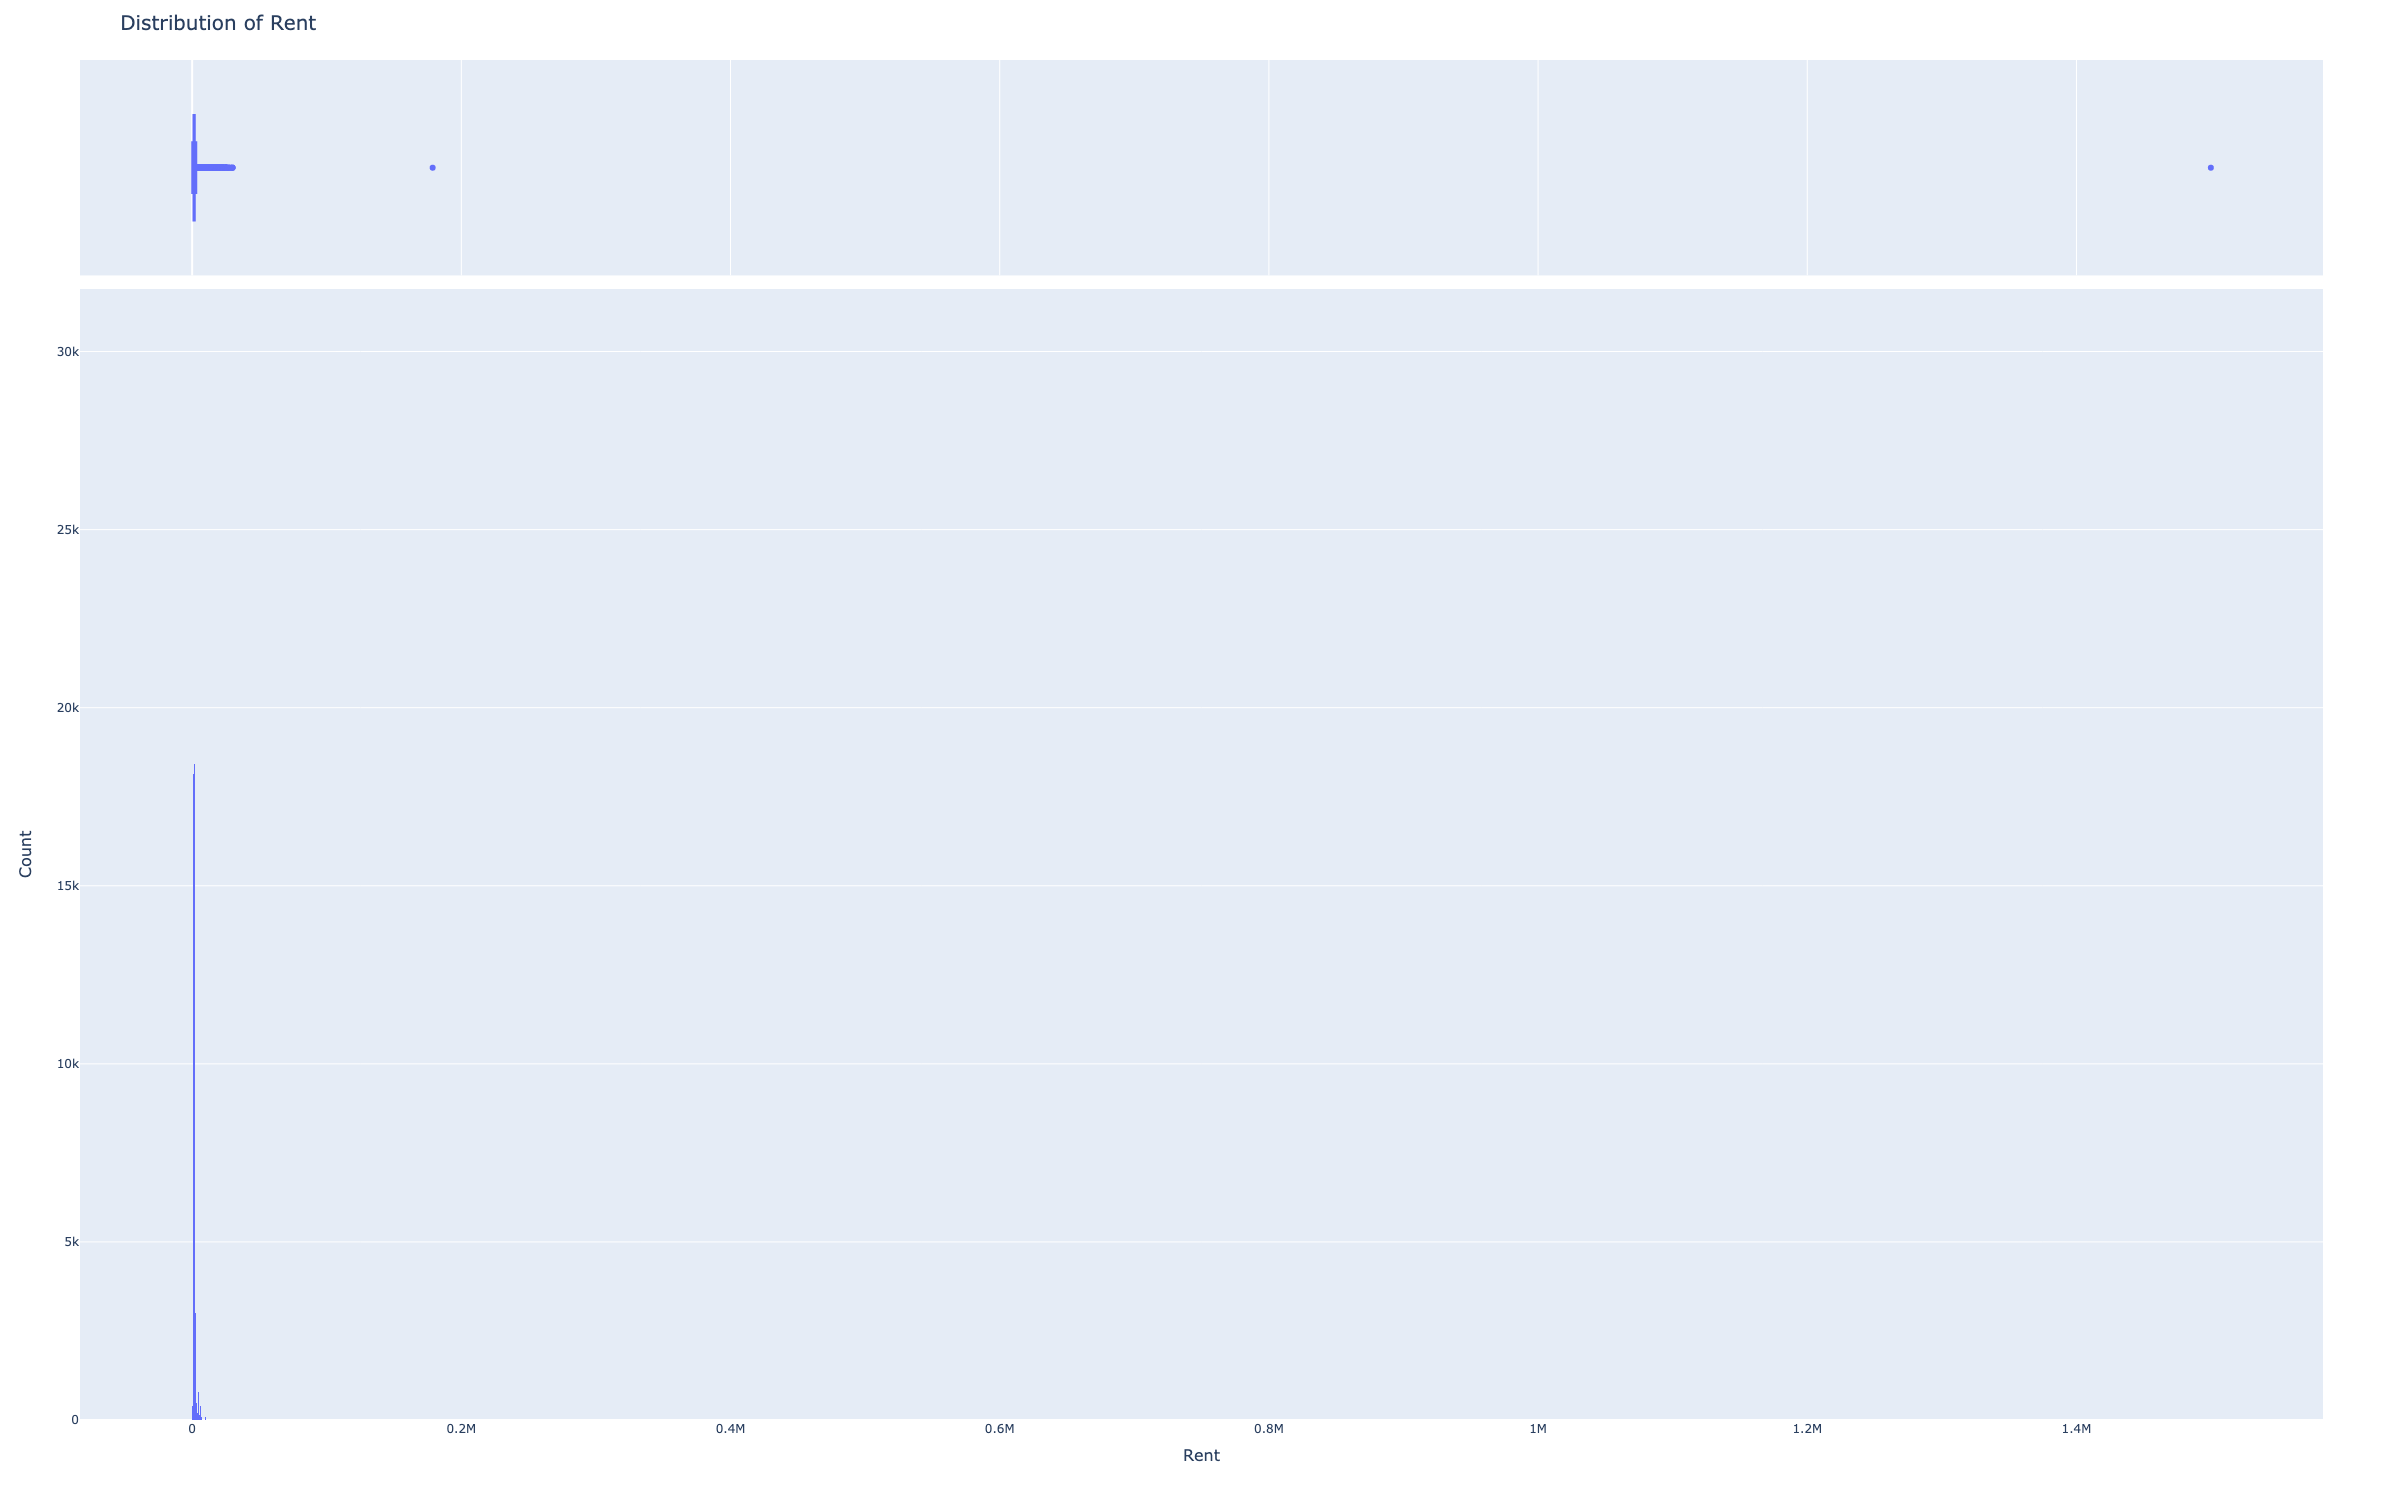

In [11]:
#Figure 1 
fig = px.histogram(df, x="a_netm_mon", marginal="box")

# Dimensions
width_inches = 8.01
height_inches = 5

#Annotations
fig.update_layout(
    legend=dict(font=dict(size=16)),
    title=dict(text="Distribution of Rent", font=dict(size=20)),
    xaxis=dict(title=dict(text="Rent", font=dict(size=16))),
    yaxis=dict(title=dict(text="Count", font=dict(size=16))),
)


dpi = 300

# Save the figure as a PNG image
pio.write_image(fig, "fig_1.png", width=int(width_inches * dpi), height=int(height_inches * dpi))

# Display the saved image in the notebook
Image(filename="fig_1.png")

#To view interactive plot in JupyterNotebook, uncomment the next line.
#fig.show()

As Figure 1 shows there seem to be some negative values for the rents which must be taken out. After taking out the negative samples the new distribution is displayed in Figure 2. Extreme positive values (over 100'000'000) are also removed as after individual evaluation are errors based on geographical location and other information of lisitng.

In [12]:
#maximum and minimum rent
df = df[df.a_netm_mon < 1000000]
df = df[df.a_netm_mon > 1]


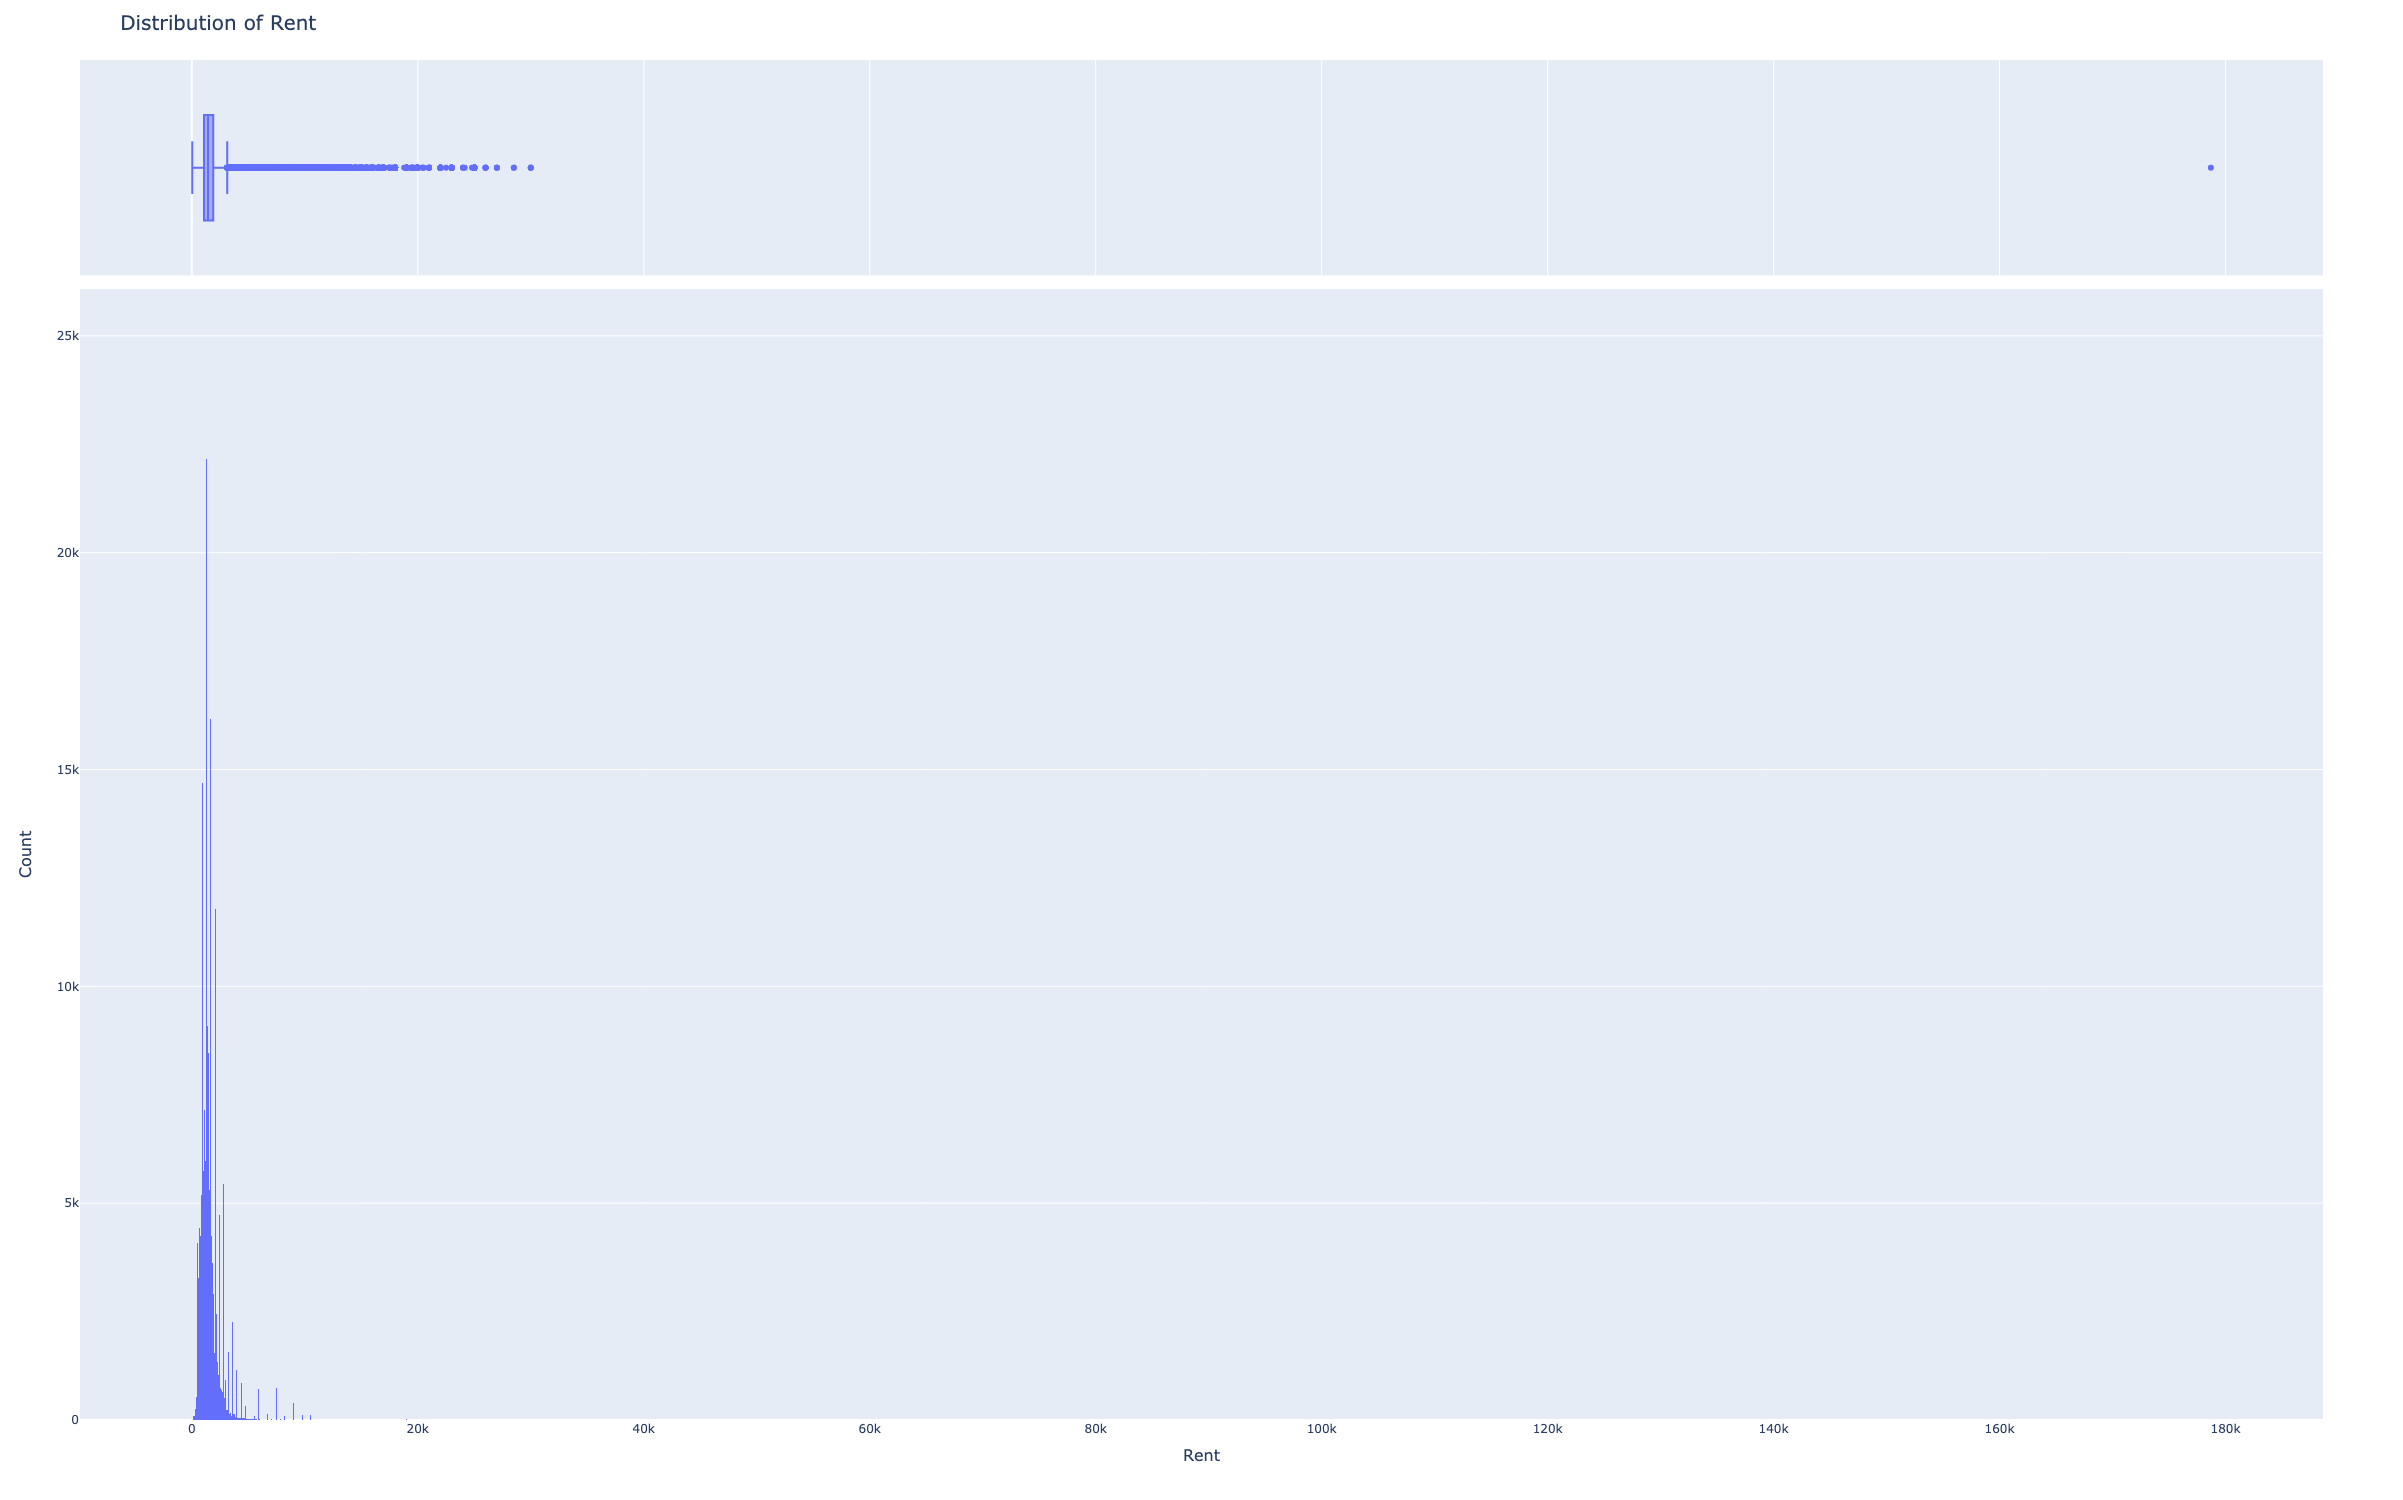

In [13]:

#Figure 2
fig = px.histogram(df, x="a_netm_mon", marginal="box")

# Dimensions
width_inches = 8.01
height_inches = 5


dpi = 300

#Annotations
fig.update_layout(
    legend=dict(font=dict(size=16)),
    title=dict(text="Distribution of Rent", font=dict(size=20)),
    xaxis=dict(title=dict(text="Rent", font=dict(size=16))),
    yaxis=dict(title=dict(text="Count", font=dict(size=16))),
)

# Save the figure as a PNG image
pio.write_image(fig, "fig_2.png", width=int(width_inches * dpi), height=int(height_inches * dpi))

# Display the saved image in the notebook
Image(filename="fig_2.png")

#To view interactive plot in JupyterNotebook, uncomment the next line.
#fig.show()

There are still many results that lie on the extremes of the distribution curve (and outside of the first and last quartile). The upper fence is at 31.52, while the most extreme to the right value is at 450. These values could be very prestigious goods, but the fact that there were only ten transactions at over 171.42 CHF per sqm makes us think they are negligible in the illustration of preferences. On the other hand, one could argue that the data set is biased given its nature (peer-to-peer platform) and that these values shout be oversampled. For this thesis, they will not be considered. However, extreme values are not necessarily outliers. To verify this within the context of this study, it would be wise to evaluate the rent per sqm; as the living surface is the primary driver of price, it makes more sense to look at the rent in relation to at least one other attribute. As figure 3 shows, there are still plenty of values outside of the lower and upper fence. These values will also be evaluated again in the Mahala Nobis distance test. After a meticulous case-by-case inspection, all data points with a rent to sqm ratio of less than 8 (14 being the minimum on the 1 October 2022 on Home Gate) were eliminated. The new distribution is show in figure 6.

In [14]:
#Adding price per square meter to evaluate ratio realism
df['psqm'] = df.apply(lambda row: row.a_netm_mon / row.a_surface_living, axis=1)

#Defining the maximum value of price per square meter
df = df[df.psqm < 170]
df = df[df.psqm > 8]

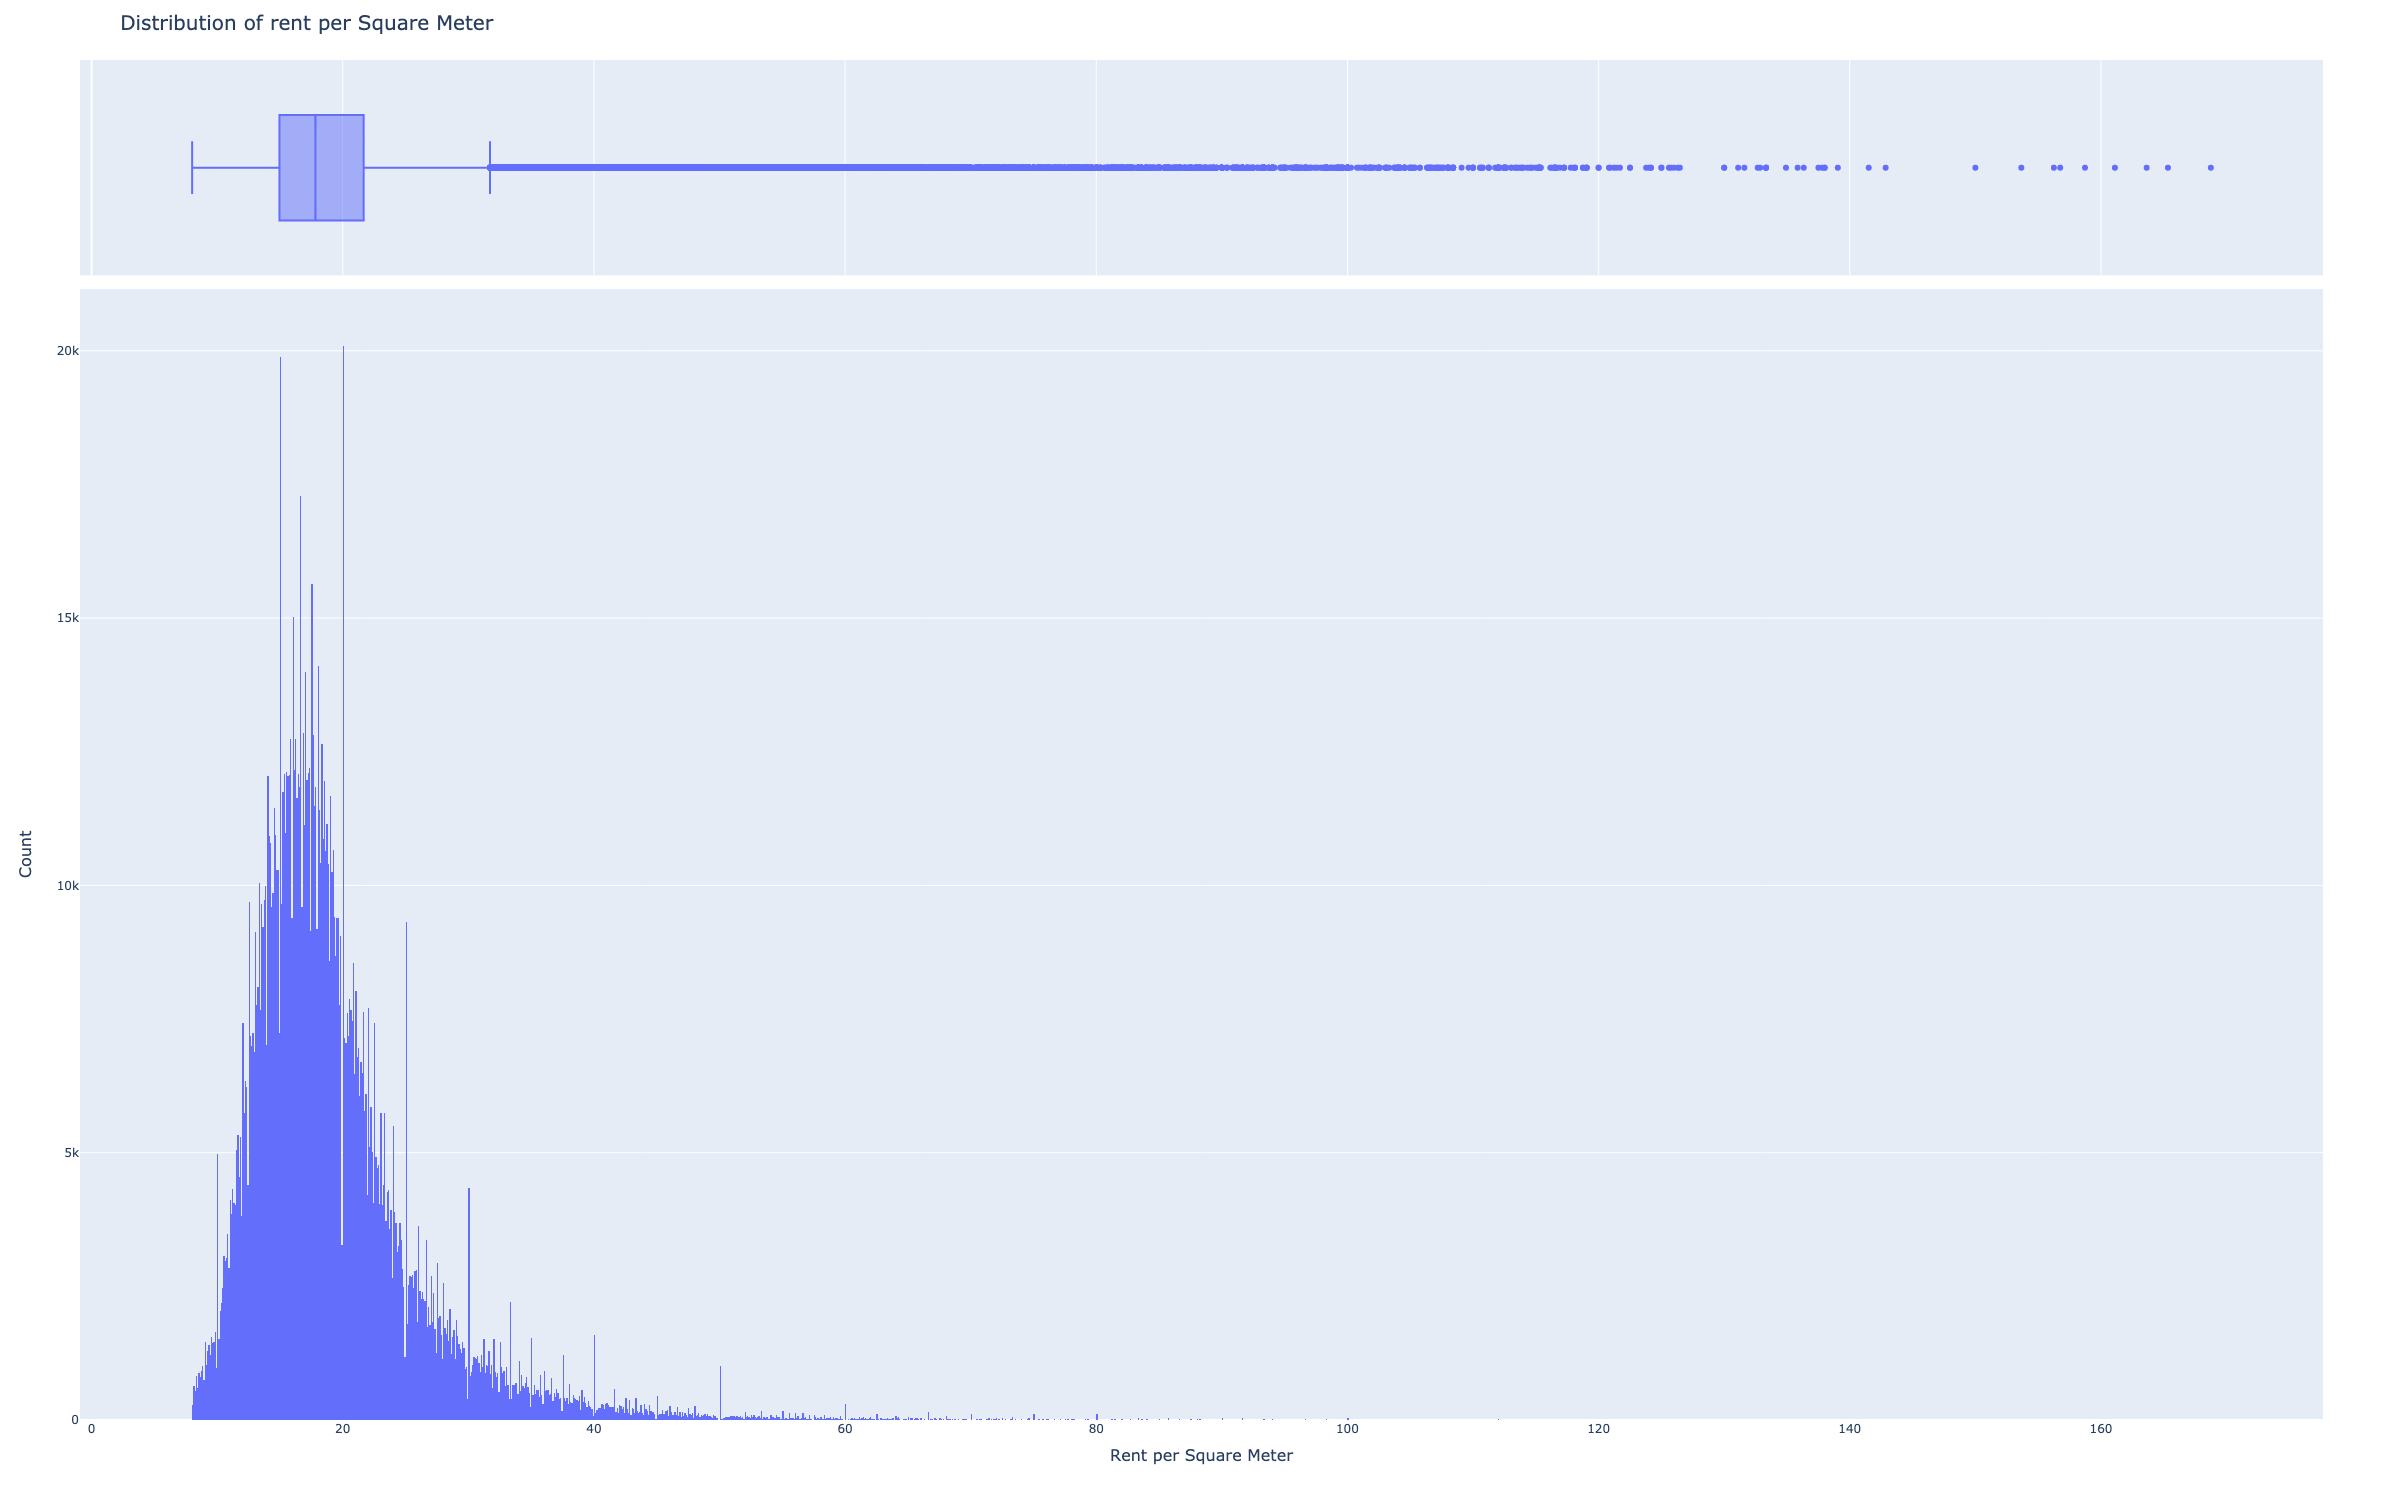

In [15]:
#Figure 3
fig = px.histogram(df, x="psqm", marginal="box")

# Dimensions
width_inches = 8.01
height_inches = 5

#Annotations
fig.update_layout(
    legend=dict(font=dict(size=16)),
    title=dict(text="Distribution of rent per Square Meter", font=dict(size=20)),
    xaxis=dict(title=dict(text="Rent per Square Meter", font=dict(size=16))),
    yaxis=dict(title=dict(text="Count", font=dict(size=16))),
)


dpi = 300

# Save the figure as a PNG image
pio.write_image(fig, "fig_3.png", width=int(width_inches * dpi), height=int(height_inches * dpi))

# Display the saved image in the notebook
Image(filename="fig_3.png")

#To view interactive plot in JupyterNotebook, uncomment the next line.
#fig.show()

**Build Year**


The following variable is the year the good was built. One challenge was the hidden NaN values under the year “9999” These had to be removed again, reducing the sample size. This is clear in figure 4, where we can see many observations at 9999. There are shy of 700’000 data samples (for a total of 1.3 million), with the building year set to 9999. In simple OLS regressions, the model was more precise with a larger data sample than without the build year as a variable.

In [16]:
#remove unkown buld year and set upper and lower limit
df.drop(df.loc[df['a_baup']== 9999].index, inplace=True)
df = df[df.a_baup < 2015]
df = df[df.a_baup > 1]

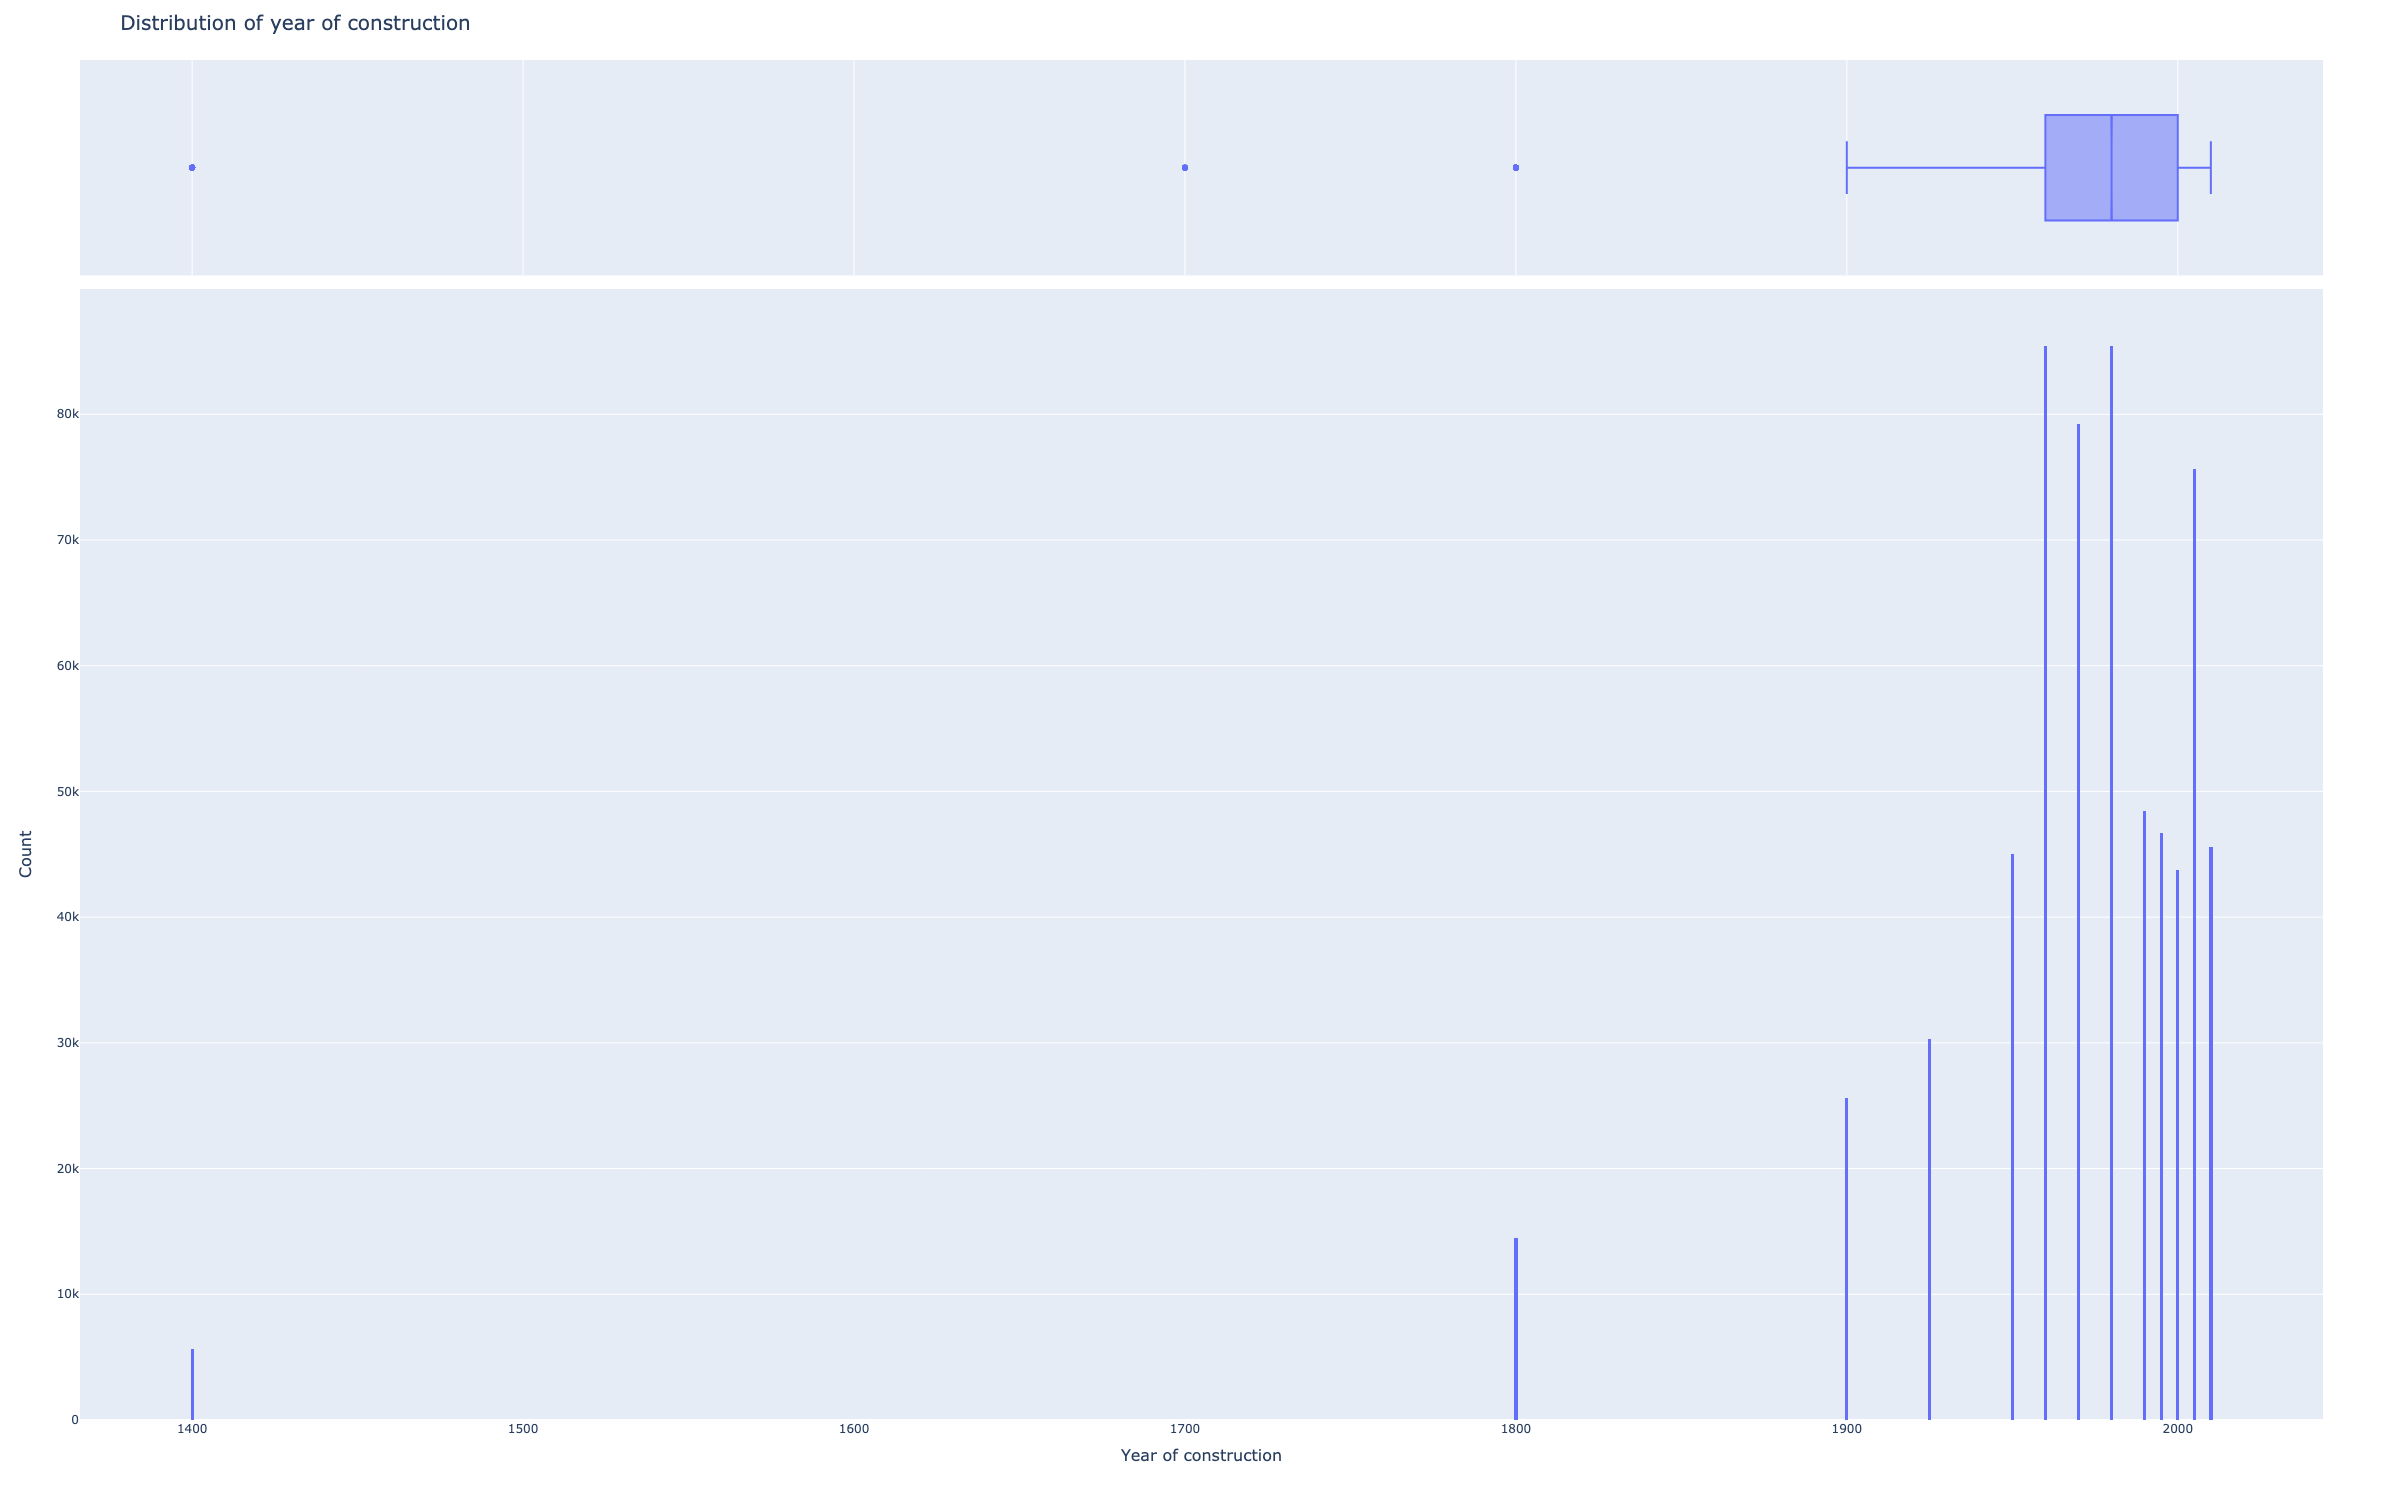

In [17]:
#Figure 4
fig = px.histogram(df, x="a_baup", marginal="box")

# Dimensions
width_inches = 8.01
height_inches = 5

#Annotations
fig.update_layout(
    legend=dict(font=dict(size=16)),
    title=dict(text="Distribution of year of construction", font=dict(size=20)),
    xaxis=dict(title=dict(text="Year of construction", font=dict(size=16))),
    yaxis=dict(title=dict(text="Count", font=dict(size=16))),
)


dpi = 300

# Save the figure as a PNG image
pio.write_image(fig, "fig_4.png", width=int(width_inches * dpi), height=int(height_inches * dpi))

# Display the saved image in the notebook
Image(filename="fig_4.png")

#To view interactive plot in JupyterNotebook, uncomment the next line.
#fig.show()

Additionally, the building years are not a continuous variable but a categorical one. This would become a problem in the regression as the large number of categories would be difficult to analyze. The categories are visible in table 1.

Thus the variable was transformed to a continuous variable. Given the large sameple size, randomly assigning specific dates to observations (within their specified periode) had no effect on an OLS regression model that was used to test if this modification had an effect. This function will only be applied to the data at the end of the outlier analysis to not alter the outputs of further multifactor analysis.

In [18]:
#regression without random year
X_before = df[["a_surface_living", "a_baup", "a_zip_2"]]
y_before = df["a_netm_mon"] 
X_before = sm.add_constant(X_before)
model_before = sm.OLS(y_before, X_before).fit()

# Print the summary of the linear regression model
#print(model_before.summary())
print(f"AIC: {model_before.aic}")

AIC: 9975673.181460606


In [19]:
#Table 1

a_baup = {1400:'1400-1799', 1800:'1800-1899', 1900:'1900-1924', 1925: '1925-1949', 1950:'1950-1959', 1960:'1960-1969', 1970:'1970-1979', 1980: '1980-1989', 1990:'1990-1994', 1995:'1995-1999', 2000:'2000-2004', 2005: '2005-2010'}

print("+------+-------------+")
print("| Code |   Period    |")
print("+------+-------------+")
for code, period in a_baup.items(): print(f"| {code:<4} | {period:<11} |")
print("+------+-------------+")

+------+-------------+
| Code |   Period    |
+------+-------------+
| 1400 | 1400-1799   |
| 1800 | 1800-1899   |
| 1900 | 1900-1924   |
| 1925 | 1925-1949   |
| 1950 | 1950-1959   |
| 1960 | 1960-1969   |
| 1970 | 1970-1979   |
| 1980 | 1980-1989   |
| 1990 | 1990-1994   |
| 1995 | 1995-1999   |
| 2000 | 2000-2004   |
| 2005 | 2005-2010   |
+------+-------------+


In [20]:
# Add new column for building year, choosing number at random
build_periods = {
    1400: (1400, 1799),
    1800: (1800, 1899),
    1900: (1900, 1924),
    1925: (1925, 1949),
    1950: (1950, 1959),
    1960: (1960, 1969),
    1970: (1970, 1979),
    1980: (1980, 1989),
    1990: (1990, 1994),
    1995: (1995, 1999),
    2000: (2000, 2004),
    2005: (2005, 2010),
}


def random_baup(row):
    a_baup = row["a_baup"]

    if a_baup not in build_periods:
        return a_baup

    begining, end = build_periods[a_baup]
    return random.randrange(begining, end + 1)

df["random_year"] = df.apply(random_baup, axis=1)

In [21]:
df.head()

,a_zip_2,a_kat_o_2,a_surface_living,a_netm_mon,a_nb_rooms,a_sicht,a_ofen,a_balkon,a_baup,g_day,longitude2,latitude2,psqm,random_year
2,4123,AP,85.0,1665.0,3.5,-1,-1,1,1980,2004-01-01,7.55488,47.5574,19.588235,1980
6,8863,AP,83.0,1540.0,4.0,2,-1,3,1990,2004-01-01,8.94853,47.1735,18.554217,1994
8,3095,AP,83.0,1100.0,3.0,-1,-1,1,1970,2004-01-01,7.42972,46.9300,13.253012,1973
9,8003,AP,120.0,2100.0,4.5,-1,-1,-1,1980,2004-01-01,8.51594,47.3707,17.500000,1985
11,9008,AP,96.0,900.0,4.0,-1,-1,-1,1925,2004-01-01,9.39118,47.4398,9.375000,1932


Comparaison of a simple regression model before and after the transformation, the AIC score is lower, indicating a better fit.

In [22]:
#regression with random year
X_before = df[["a_surface_living", "random_year", "a_zip_2"]]
y_before = df["a_netm_mon"] 


X_before = sm.add_constant(X_before)
model_after = sm.OLS(y_before, X_before).fit()

# Print the summary of the linear regression model
#print(model_before.summary())
print(f"AIC: {model_after.aic}")

AIC: 9975701.292382596


Adding the age variable.

In [23]:
df['transac_year'] = pd.DatetimeIndex(df['g_day']).year
df['age'] = df.apply(lambda row: row.transac_year - row.random_year, axis=1)

**Living Surface**


The same procedure as for the rent is carried out for the living surface. Intuitively many of the outliers have already been taken out in the price-to-square-meter analysis. 

<div style="background-color: yellow; padding: 10px">
WARNING: PROBLEM WITH VISUALISATION OF IMAGE OF THROUGH PICTURE (BAD RENDER), TO VIEW ACTUAL DISTRIBUTION UNCOMMENT INTERACTIVE PLOT. 
</div>
    Be aware of the RAM space folium graphs occupy. It is not avised to render more than 3 interactive plots at a time in a notebook.

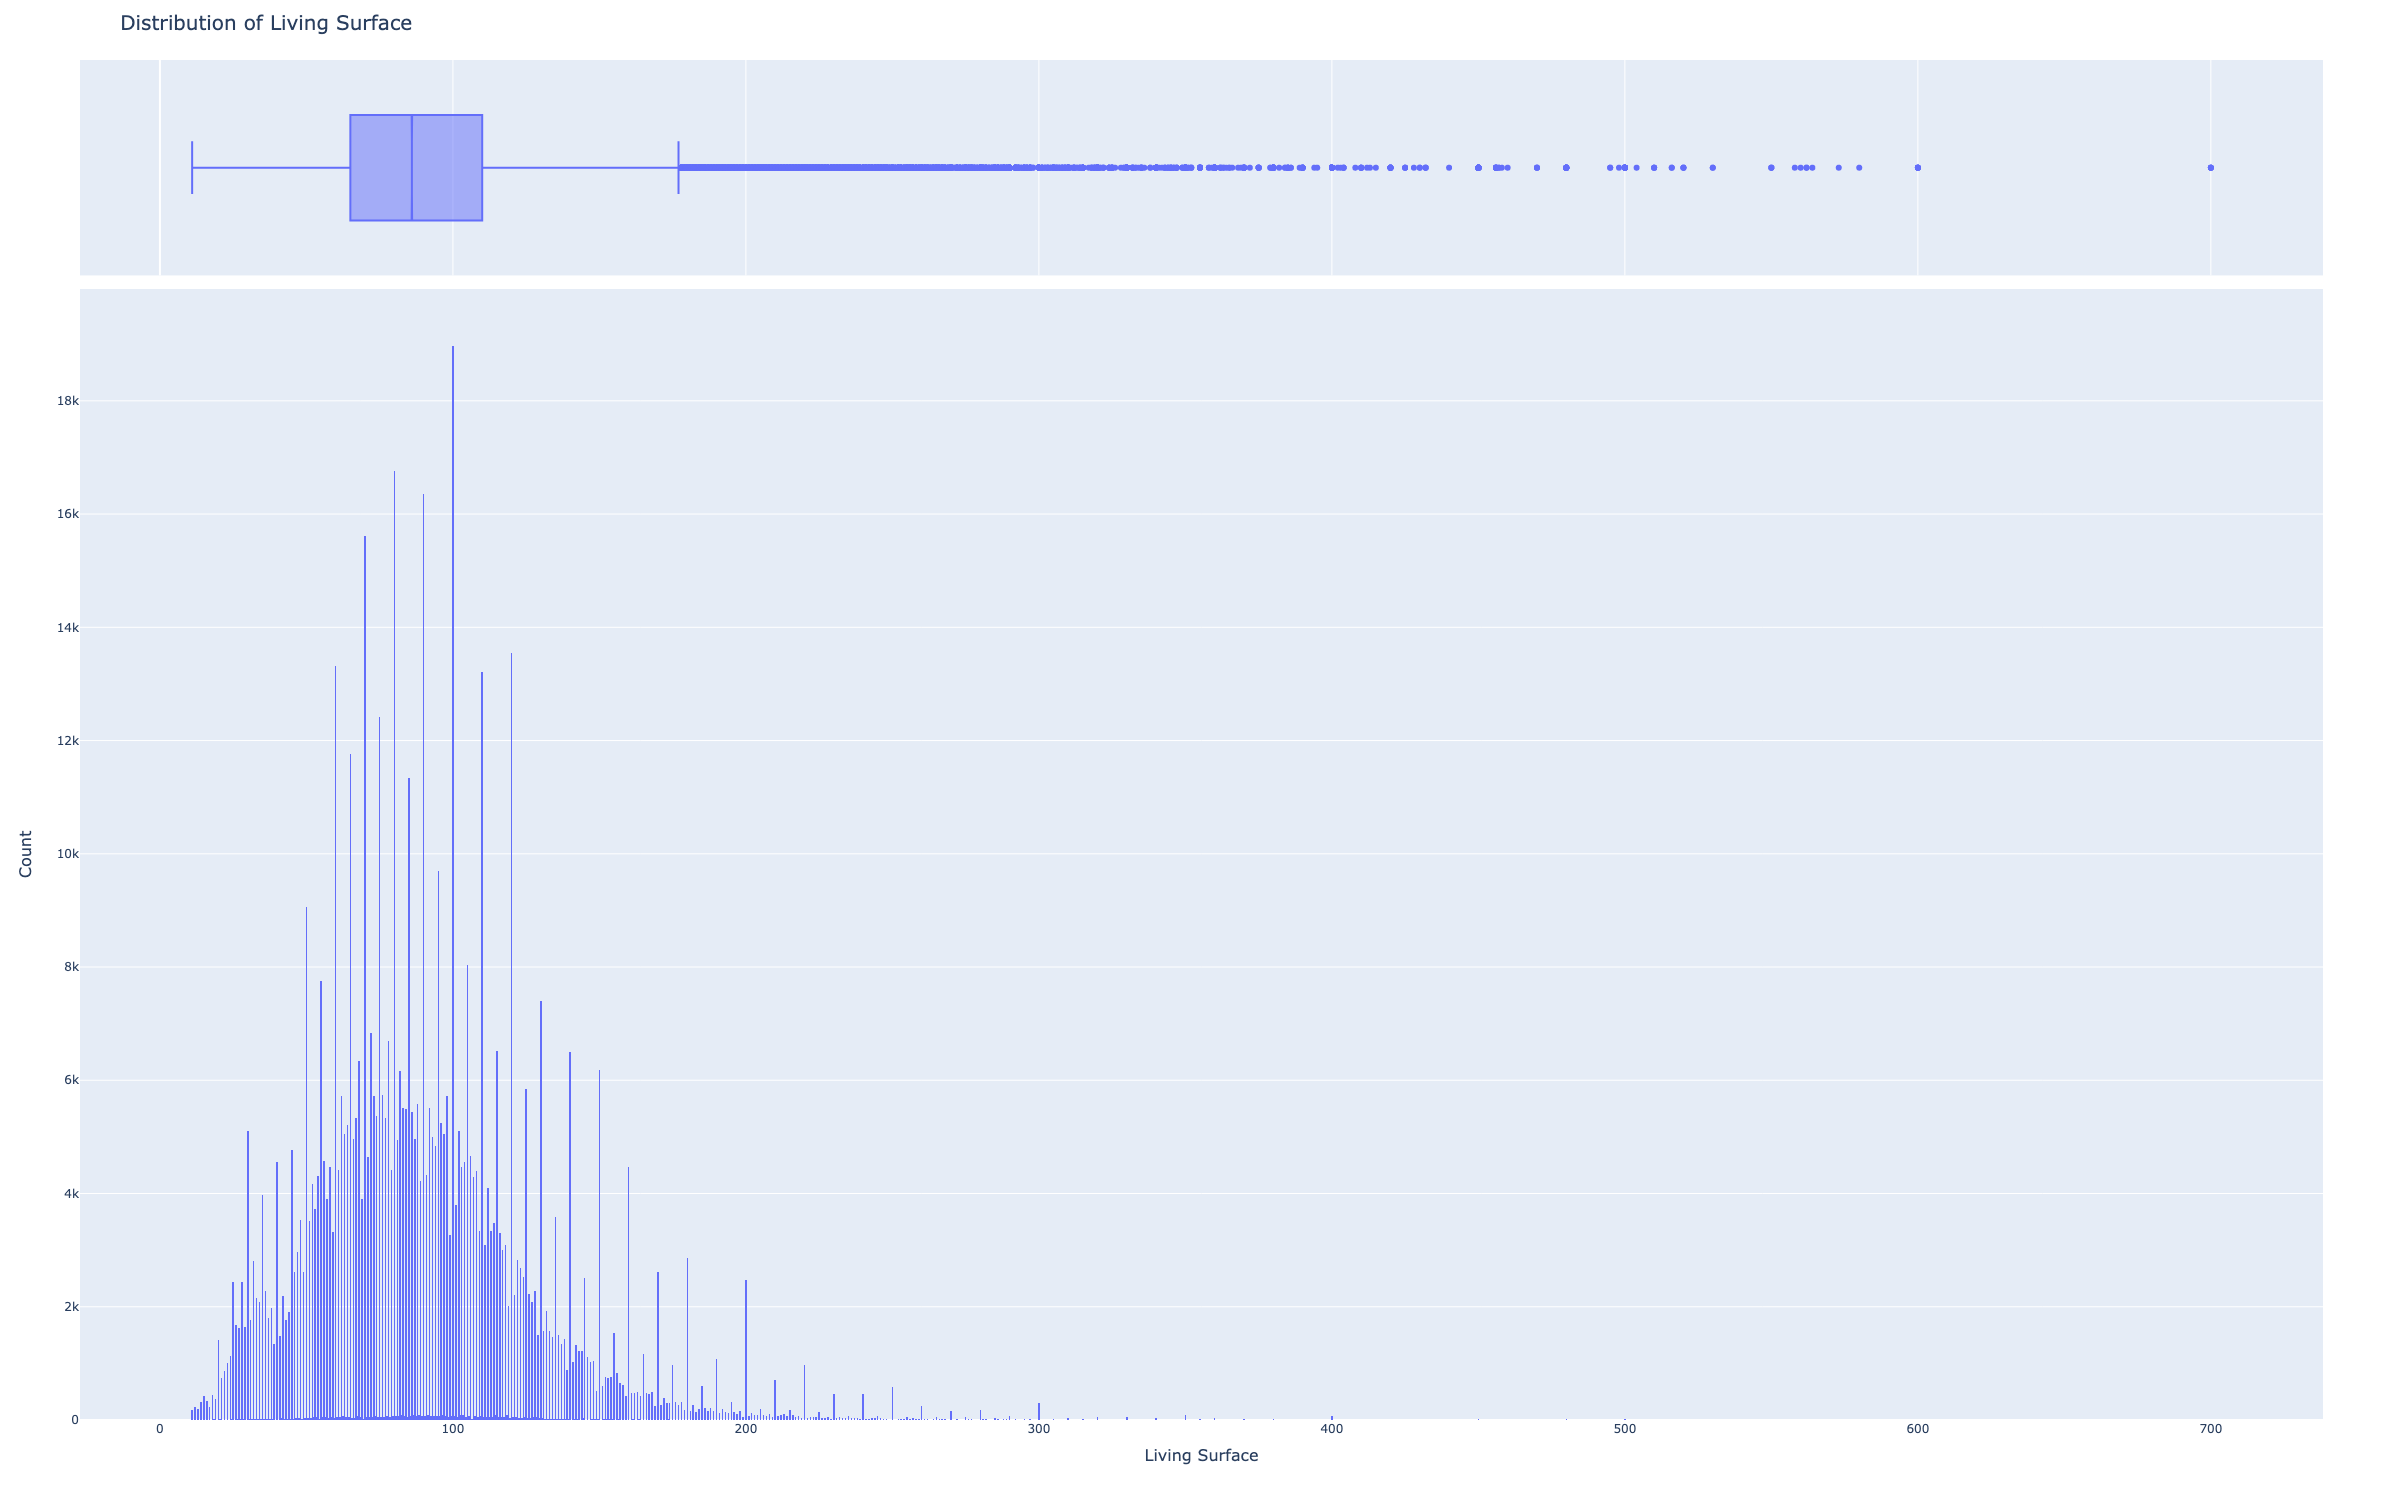

In [24]:
#Figure 5
fig = px.histogram(df, x="a_surface_living", marginal="box")

width_inches = 8.01
height_inches = 5

fig.update_layout(
    legend=dict(font=dict(size=16)),
    title=dict(text="Distribution of Living Surface", font=dict(size=20)),
    xaxis=dict(title=dict(text="Living Surface", font=dict(size=16))),
    yaxis=dict(title=dict(text="Count", font=dict(size=16))),
)


dpi = 300

# Save the figure as a PNG image
pio.write_image(fig, "fig_5.png", width=int(width_inches * dpi), height=int(height_inches * dpi))

# Display the saved image in the notebook
Image(filename="fig_5.png")

#To view interactive plot in JupyterNotebook, uncomment the next line.
#fig.show()

Similarly to the rent, there are still a relatively large number of data points far beyond the upper fence. This however as well does not necessarily mean they are outliers. But looking at these points again from a rent-to- sqm perspective it is clear that there are many data points with prices per sqm of less than 2 CHF. Additionally, on google maps satelite view, many of these extreme data points find themselves in city centers where this price point is very unlikely. Otherwise, some of them were industrial buildings, possibly indicating a warehouse or office space but unlikely residential housing.  

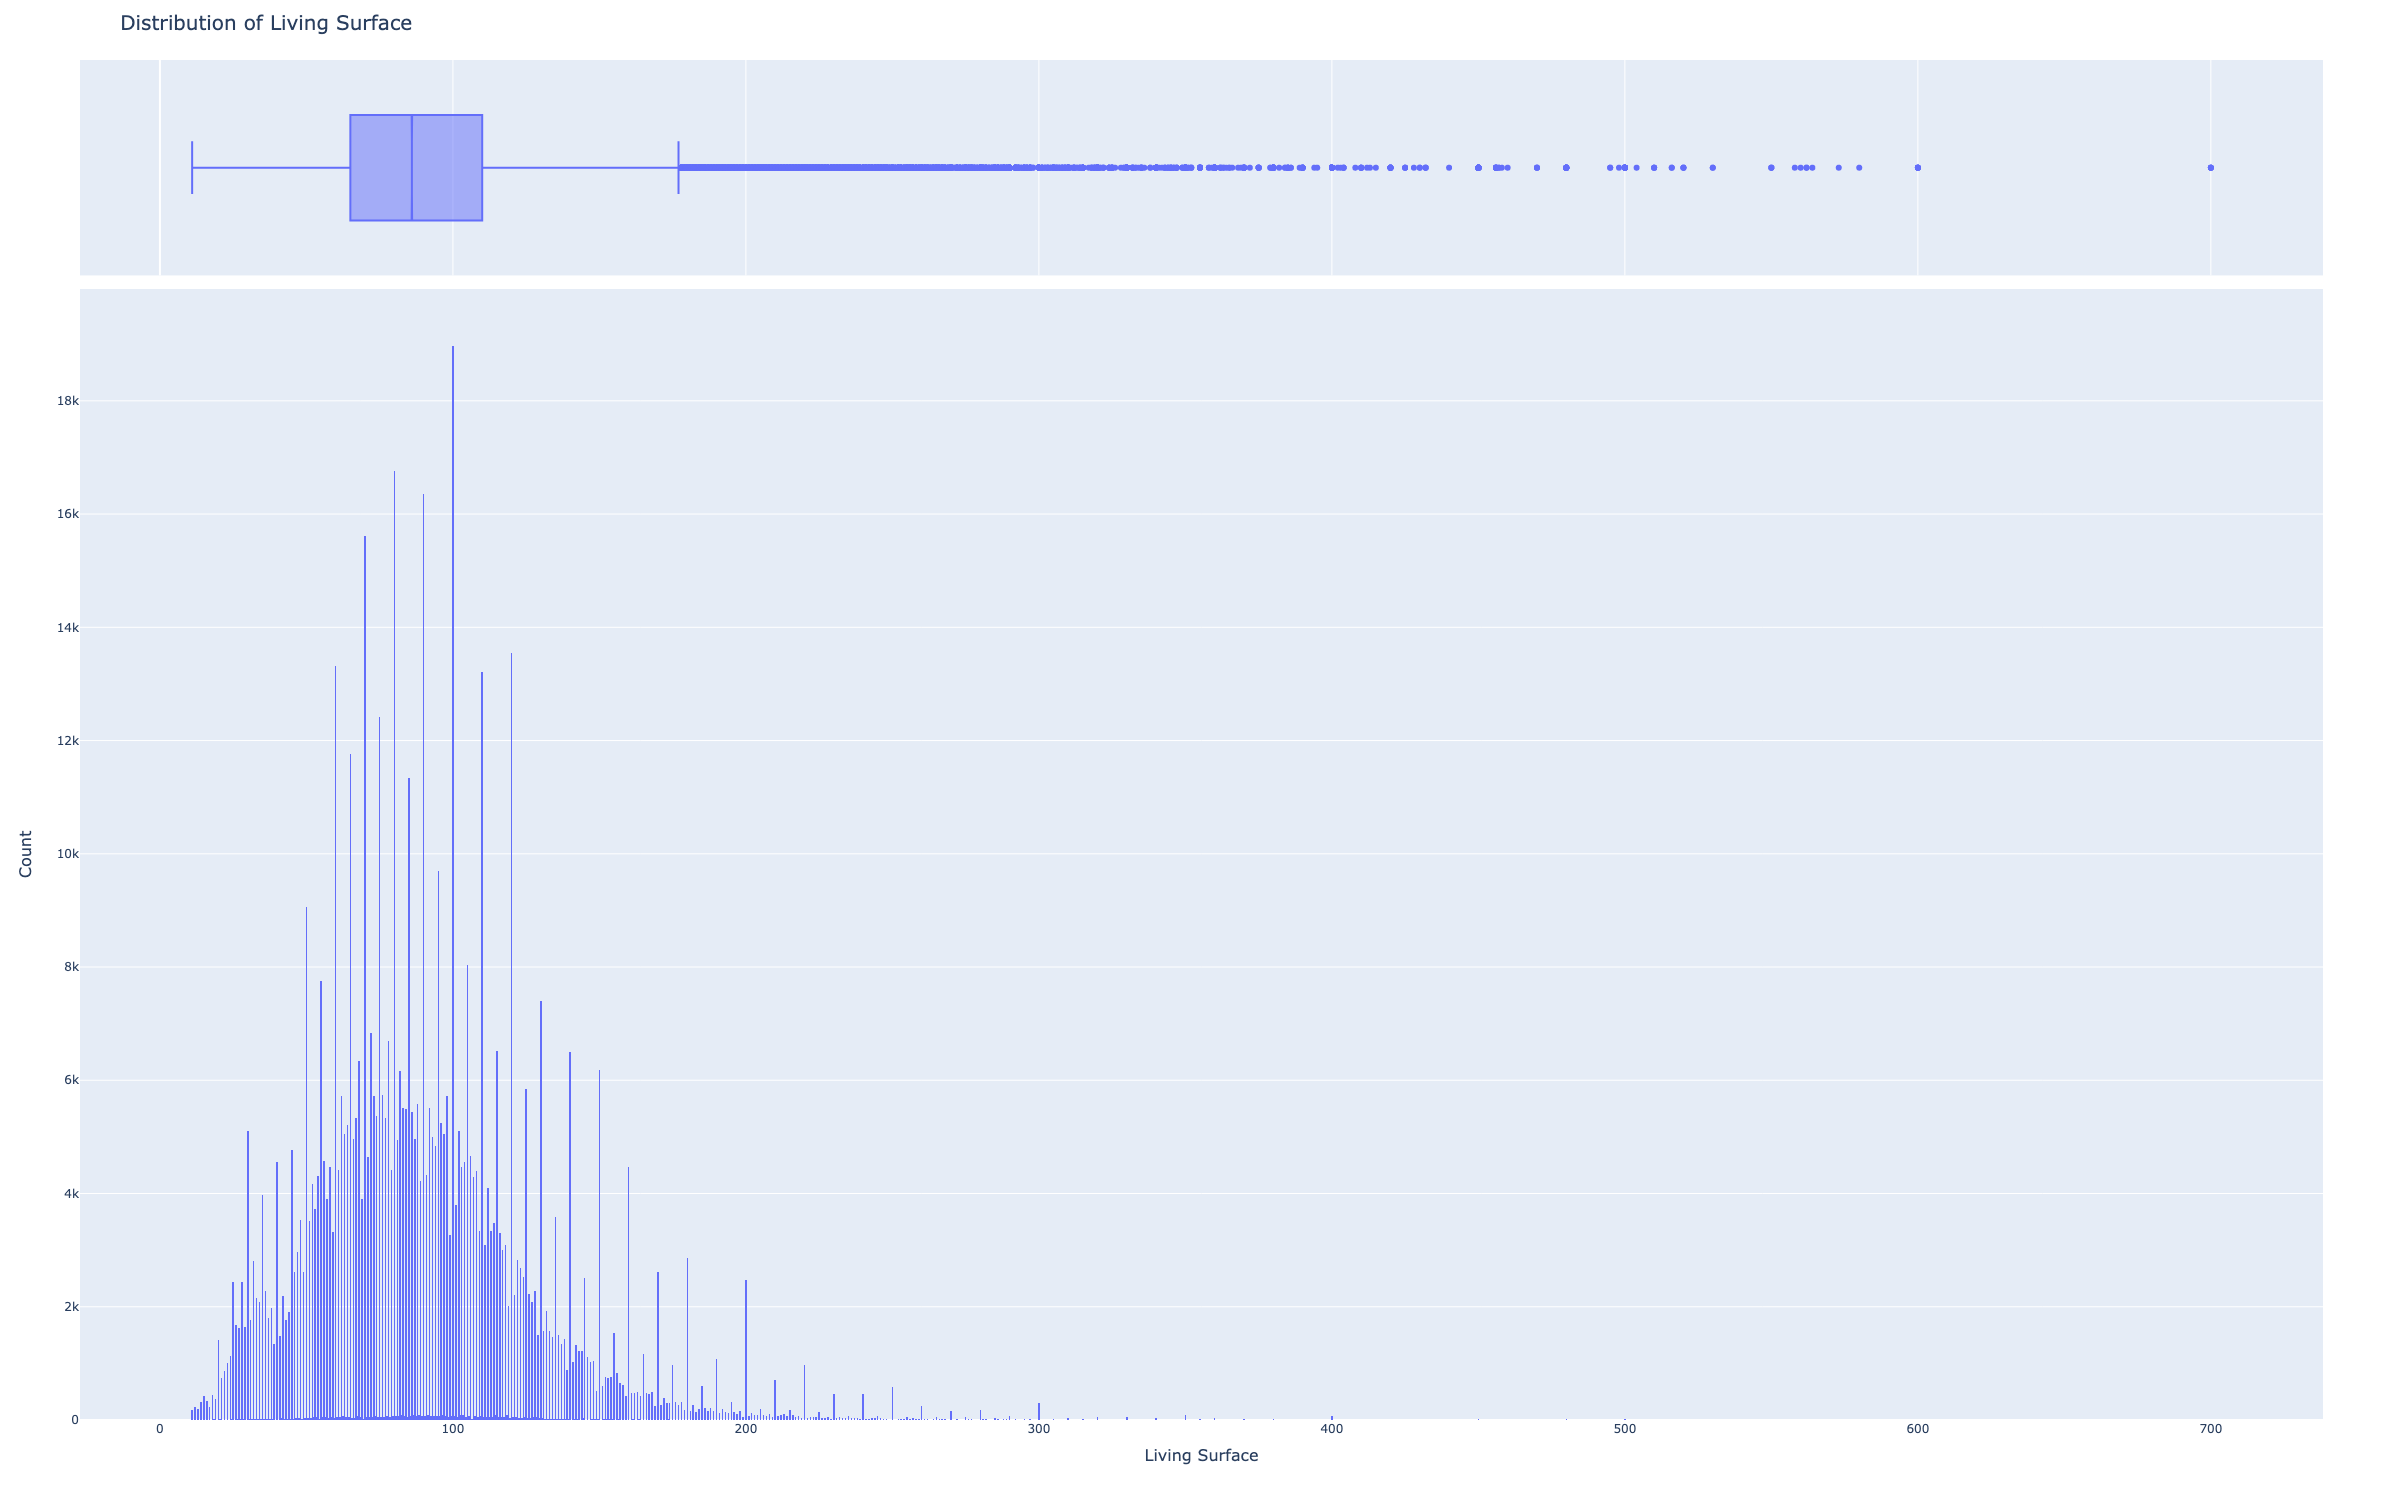

In [25]:
#Figure 6
fig = px.histogram(df, x="a_surface_living", marginal="box")

# Dimensions
width_inches = 8.01
height_inches = 5

#Annotations
fig.update_layout(
    legend=dict(font=dict(size=16)),
    title=dict(text="Distribution of Living Surface", font=dict(size=20)),
    xaxis=dict(title=dict(text="Living Surface", font=dict(size=16))),
    yaxis=dict(title=dict(text="Count", font=dict(size=16))),
)


dpi = 300

# Save the figure as a PNG image
pio.write_image(fig, "fig_6.png", width=int(width_inches * dpi), height=int(height_inches * dpi))

# Display the saved image in the notebook
Image(filename="fig_6.png")

#To view interactive plot in JupyterNotebook, uncomment the next line.
#fig.show()

**Number of rooms**


Figure 7 shows a good to have 10 million rooms, which seems unlikely so it is removed.



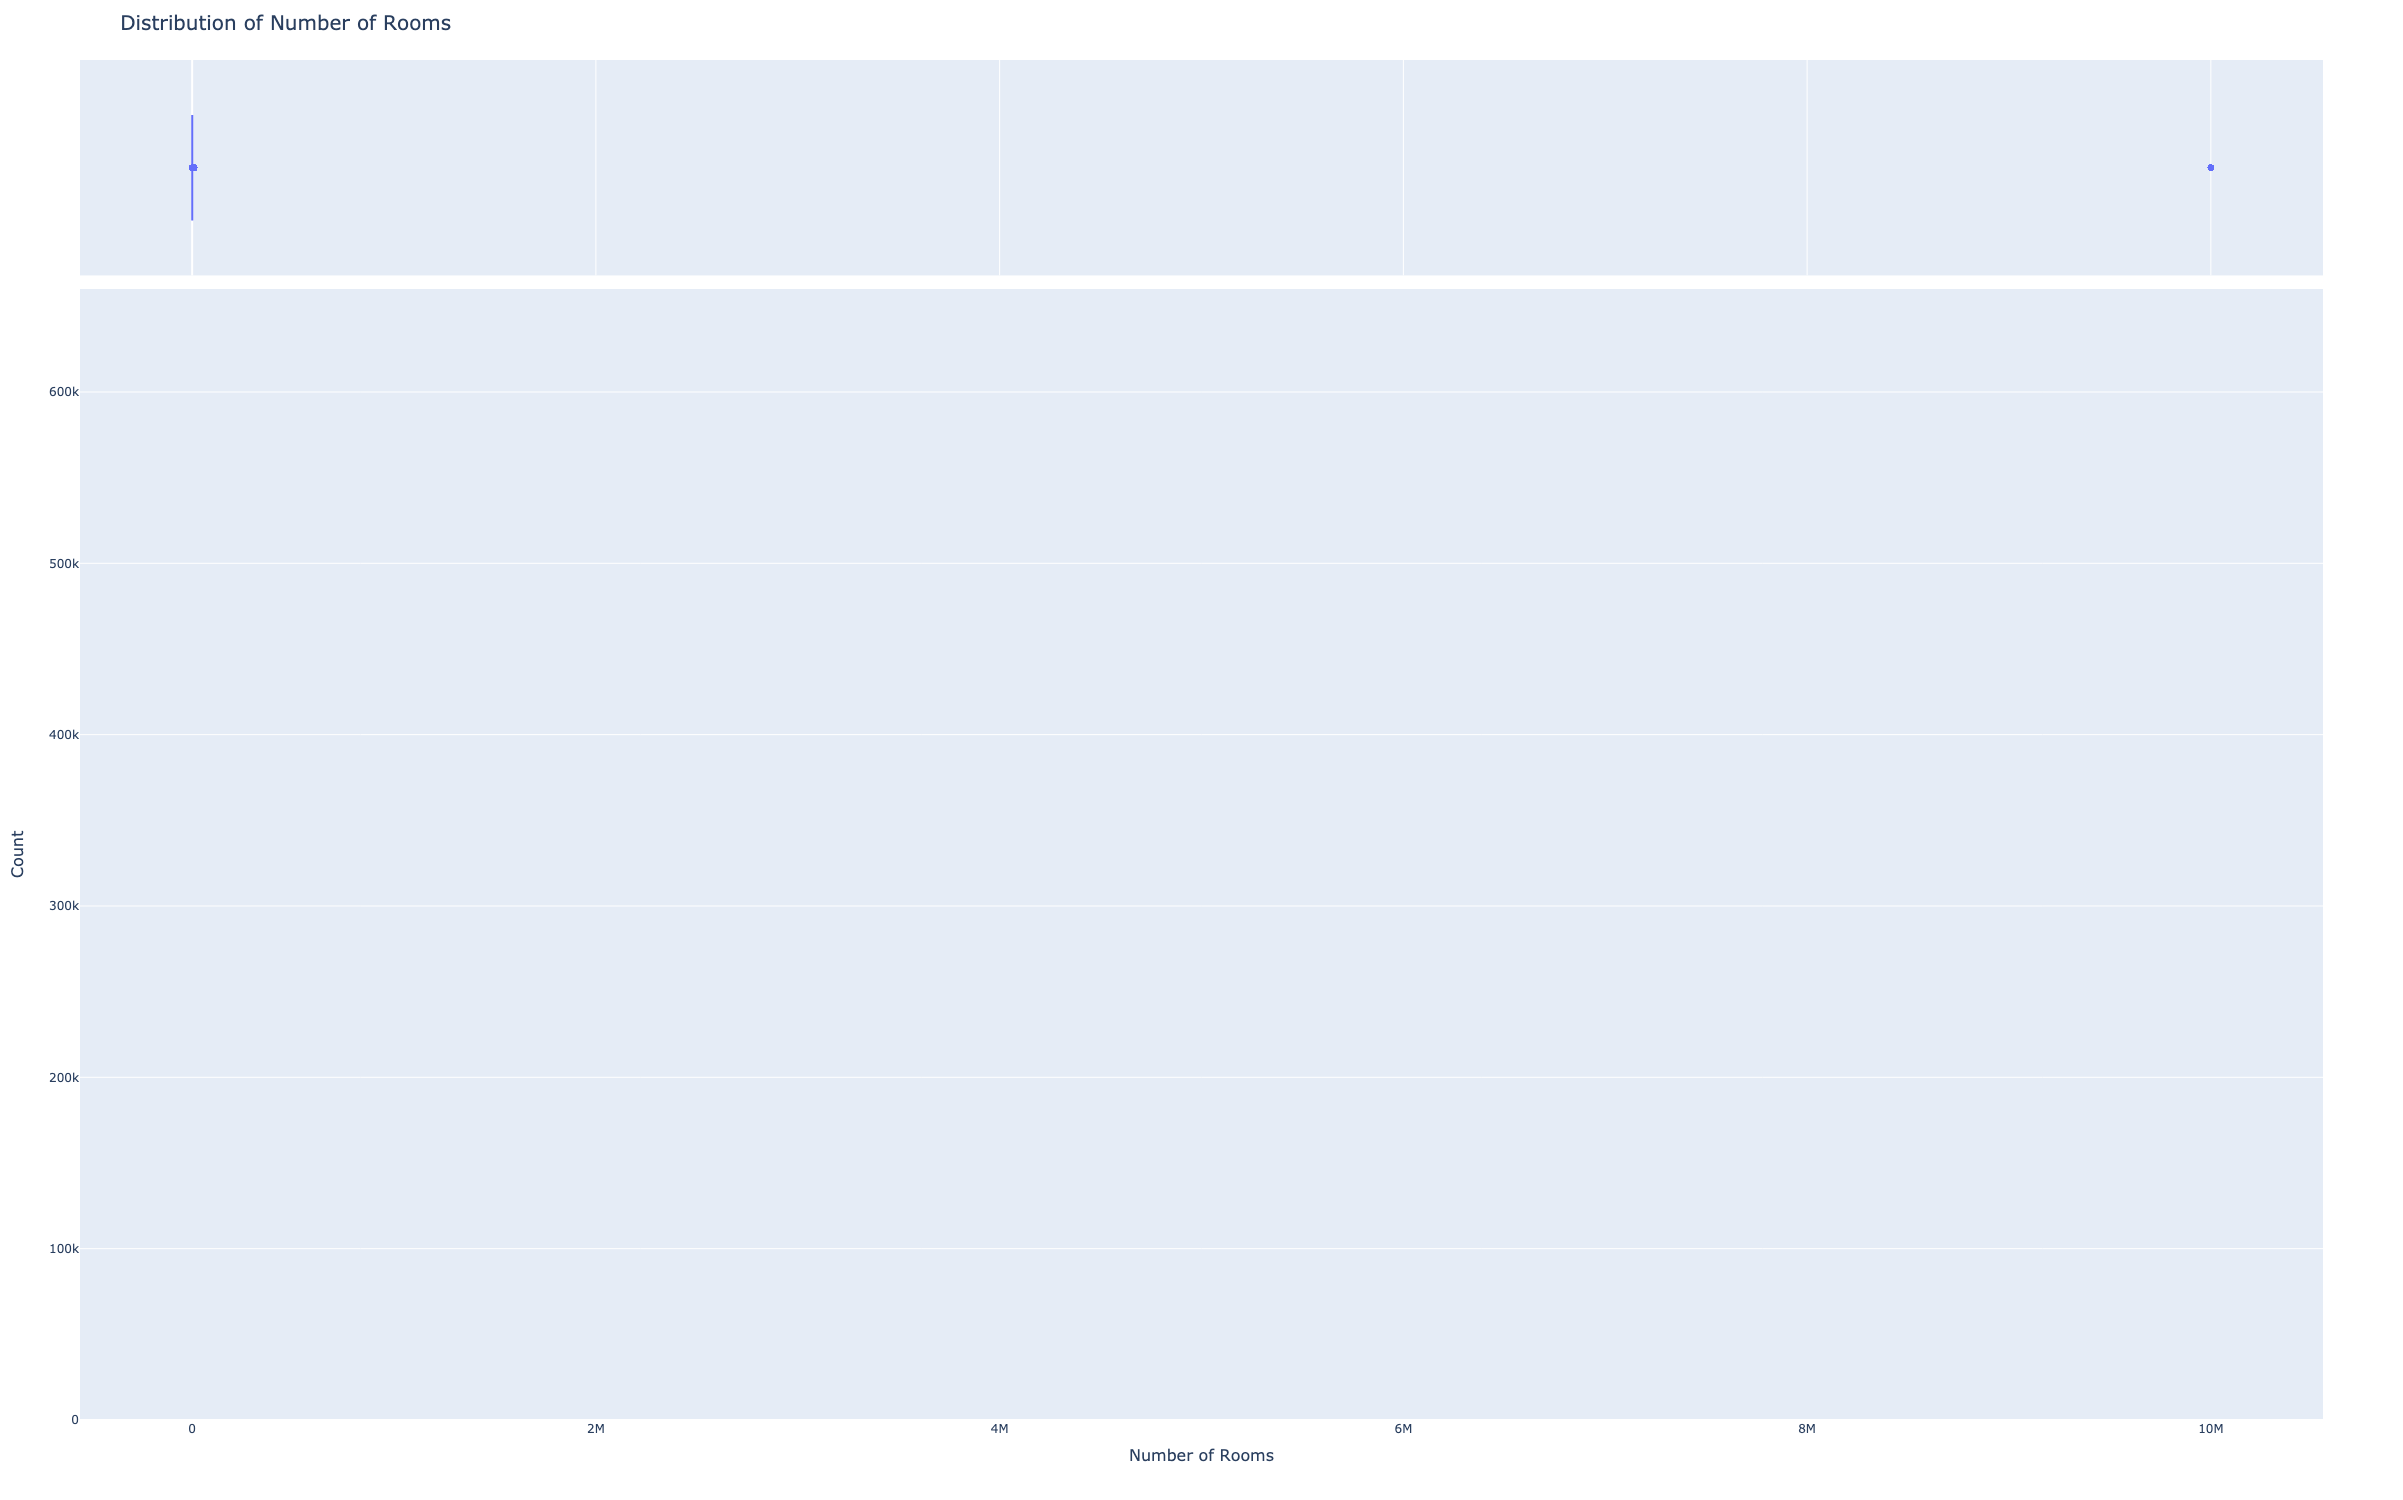

In [26]:
#Figure 7
fig = px.histogram(df, x="a_nb_rooms", marginal="box")

# Dimensions
width_inches = 8.01
height_inches = 5

#Annotations
fig.update_layout(
    legend=dict(font=dict(size=16)),
    title=dict(text="Distribution of Number of Rooms", font=dict(size=20)),
    xaxis=dict(title=dict(text="Number of Rooms", font=dict(size=16))),
    yaxis=dict(title=dict(text="Count", font=dict(size=16))),
)

dpi = 300

# Save the figure as a PNG image
pio.write_image(fig, "fig_7.png", width=int(width_inches * dpi), height=int(height_inches * dpi))

# Display the saved image in the notebook
Image(filename="fig_7.png")

#To view interactive plot in JupyterNotebook, uncomment the next line.
#fig.show()

As figure 7 shows, the distribution is now more realistic; there are still about 2000 samples with more than 8.5 rooms. Performing a case-by-case analysis on google maps, most of them are mistakes. However, some seem real, as the satellite view makes big houses visible. As mentioned before, there is a low amount of high- end properties in the data set; thus, eliminating all goods with over 8.5 rooms would make that even worse. Two thousand entries over 1.3 million are not overly significant. Thus they are not removed. Several lines with non-standard room numbers (4.4, 5.7, etc.) are removed.

In [27]:
df = df[df.a_nb_rooms < 30] 
df.drop(df.loc[df['a_nb_rooms']==1.04].index, inplace=True)
df.drop(df.loc[df['a_nb_rooms']==1.07].index, inplace=True) 
df.drop(df.loc[df['a_nb_rooms']== 0.5].index, inplace=True)

Figure 8 shows the new distribution after the removal of unconventional room numbers.

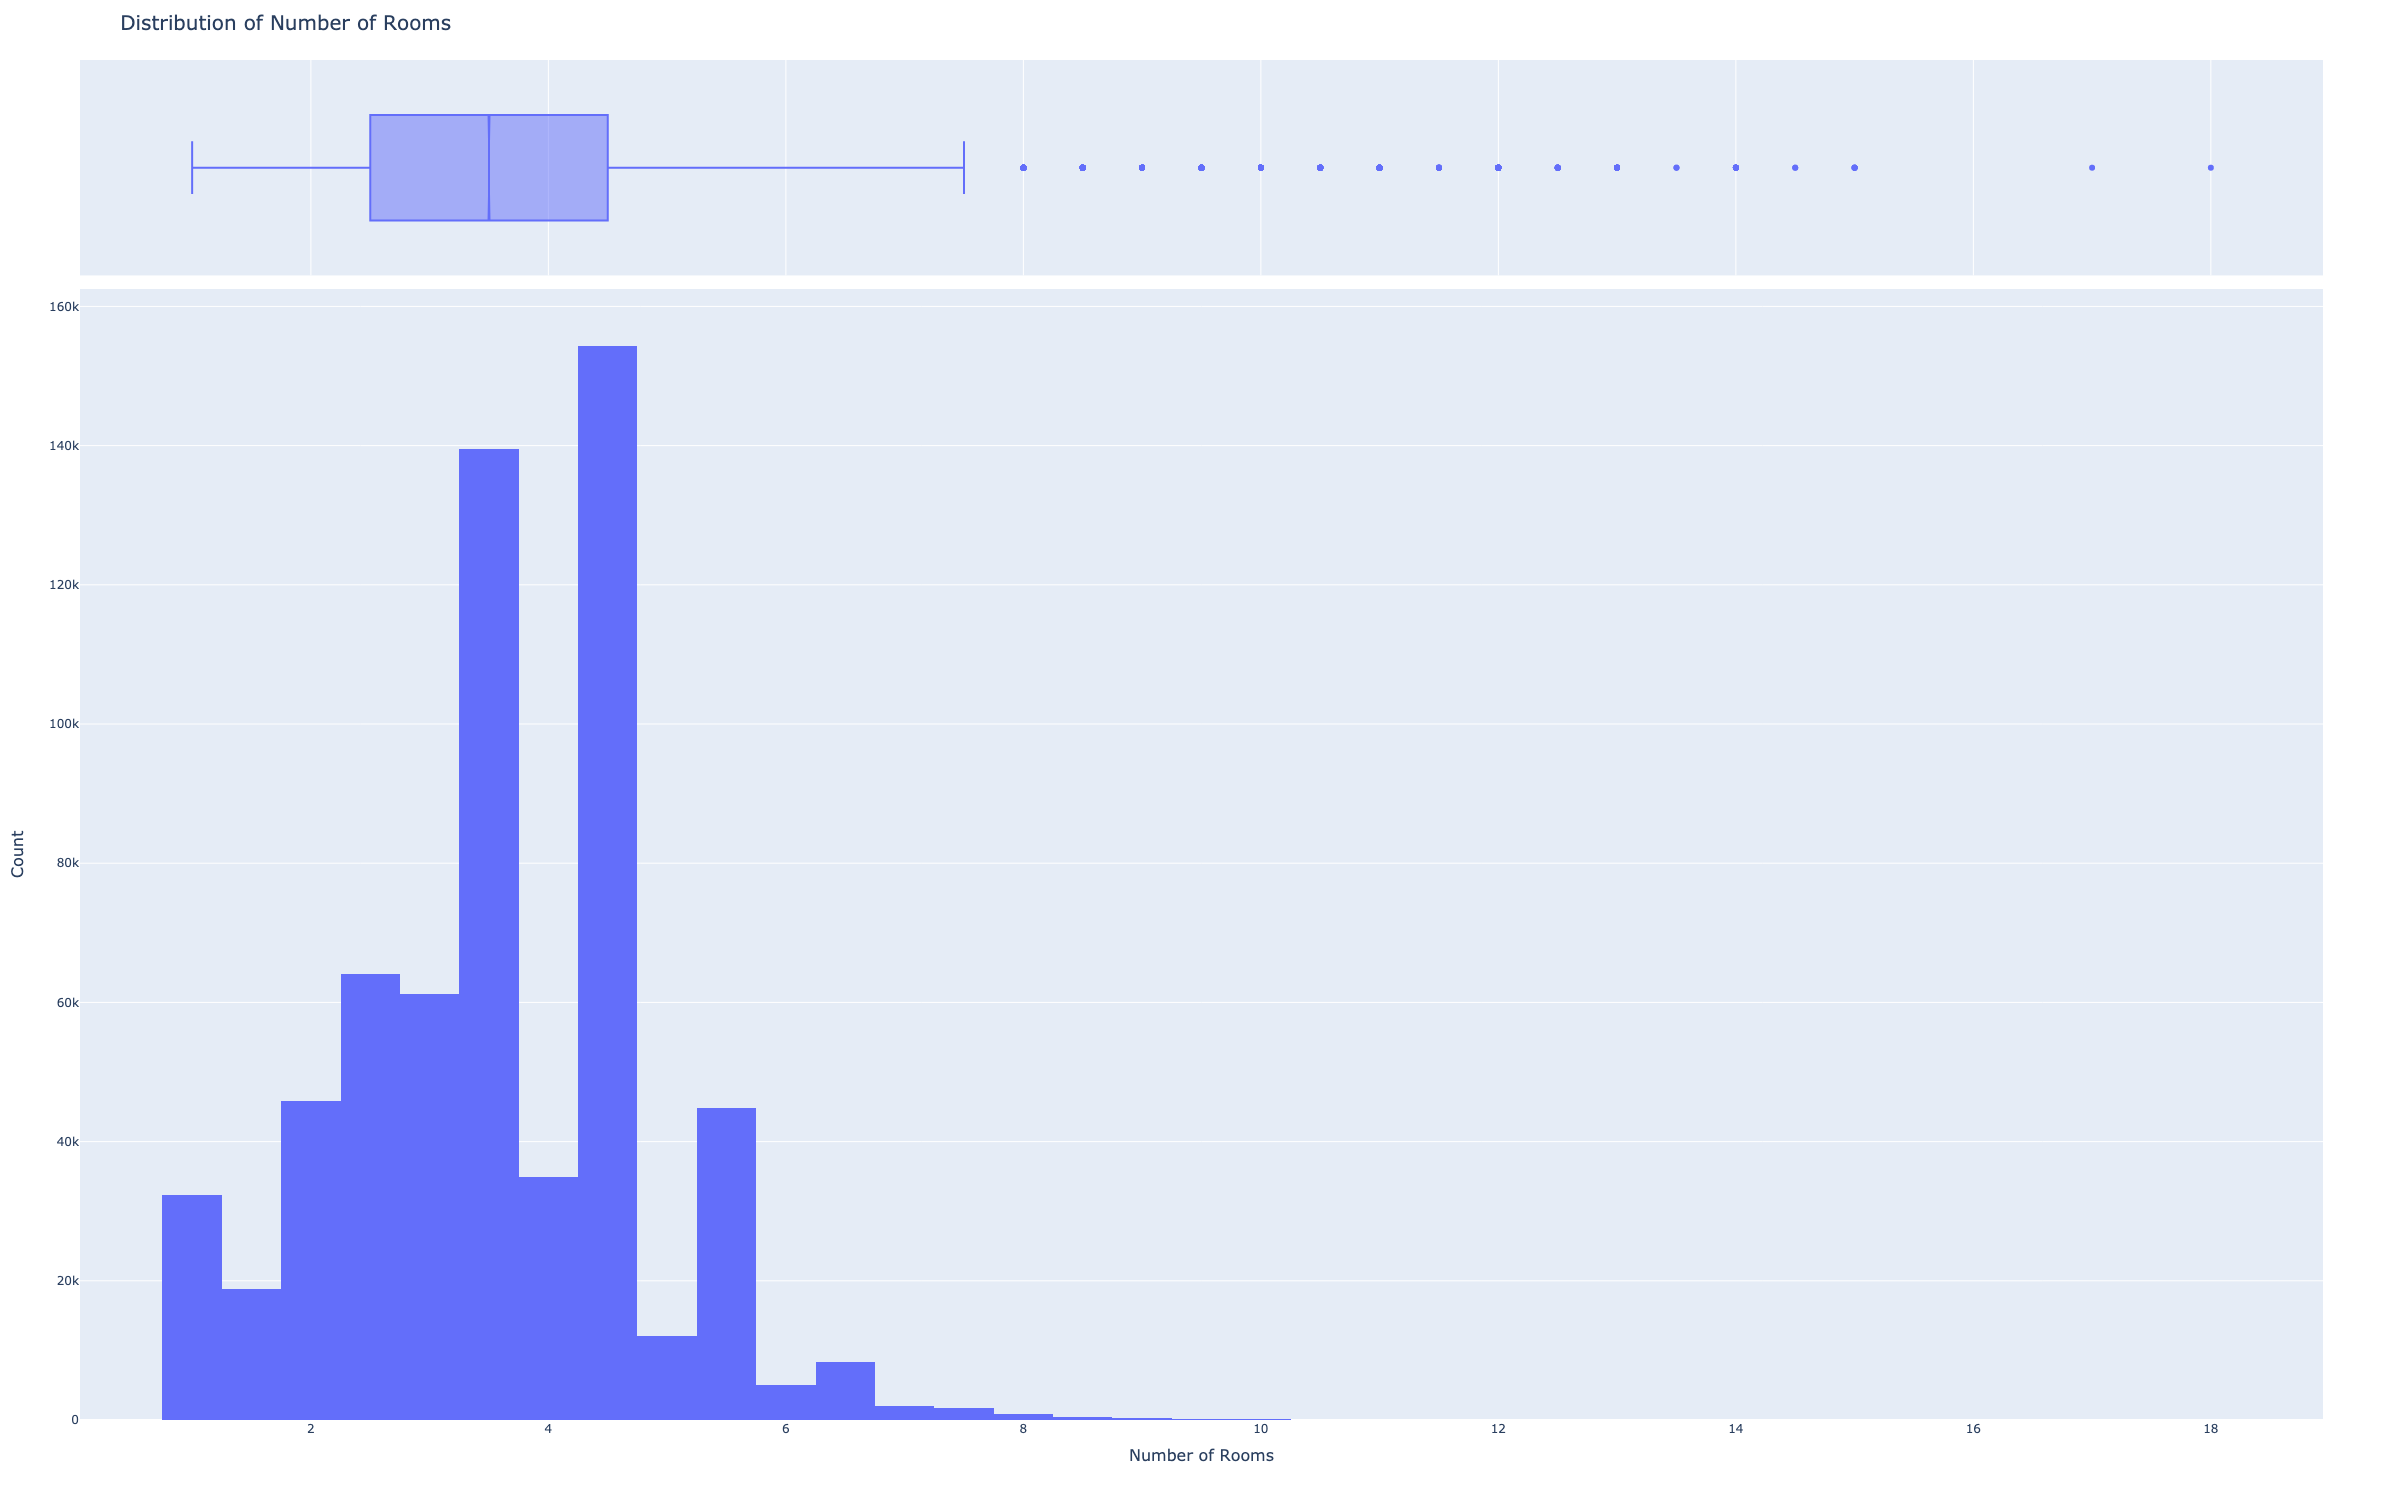

In [28]:
#Figure 8
fig = px.histogram(df, x="a_nb_rooms", marginal="box")

# Dimensions
width_inches = 8.01
height_inches = 5

#Annotations
fig.update_layout(
    legend=dict(font=dict(size=16)),
    title=dict(text="Distribution of Number of Rooms", font=dict(size=20)),
    xaxis=dict(title=dict(text="Number of Rooms", font=dict(size=16))),
    yaxis=dict(title=dict(text="Count", font=dict(size=16))),
)


dpi = 300

# Save the figure as a PNG image
pio.write_image(fig, "fig_8.png", width=int(width_inches * dpi), height=int(height_inches * dpi))

# Display the saved image in the notebook
Image(filename="fig_8.png")

#To view interactive plot in JupyterNotebook, uncomment the next line.
#fig.show()

**View, Balcony and Region**


In [29]:
df["a_sicht"] = df["a_sicht"].replace(-1, 0)
df.drop(df.loc[df['a_balkon']==-1].index, inplace=True) #unkown entry code
switzerland_bbox = [45.817, 5.955, 47.808, 10.492]
df = df[(df['latitude2'].between(switzerland_bbox[0], switzerland_bbox[2])) & (df['longitude2'].between(switzerland_bbox[1], switzerland_bbox[3]))]
grouped = df.groupby(['latitude2', 'longitude2']).size().reset_index(name='count')

print(grouped.head())

   latitude2  longitude2  count
0    45.8266     9.01177      1
1    45.8273     9.01075      5
2    45.8322     9.02232      1
3    45.8328     9.02410      1
4    45.8329     9.02074      4


The view takes -1 as a value when it is unknown whether there is a view. Eliminating all data which has -1 would be quite a significant loss. Thus it is replaced with 0 which stands for no view. It also seems unlikely that an advertiser would forget to say that his property has a nice view. Otherwise, outliers in these categorical variables are difficult to detect with single-factor methods. Same procedure is applied for the balcony. Lastly, a few datapoints were located outside of Swizerland, they were removed.

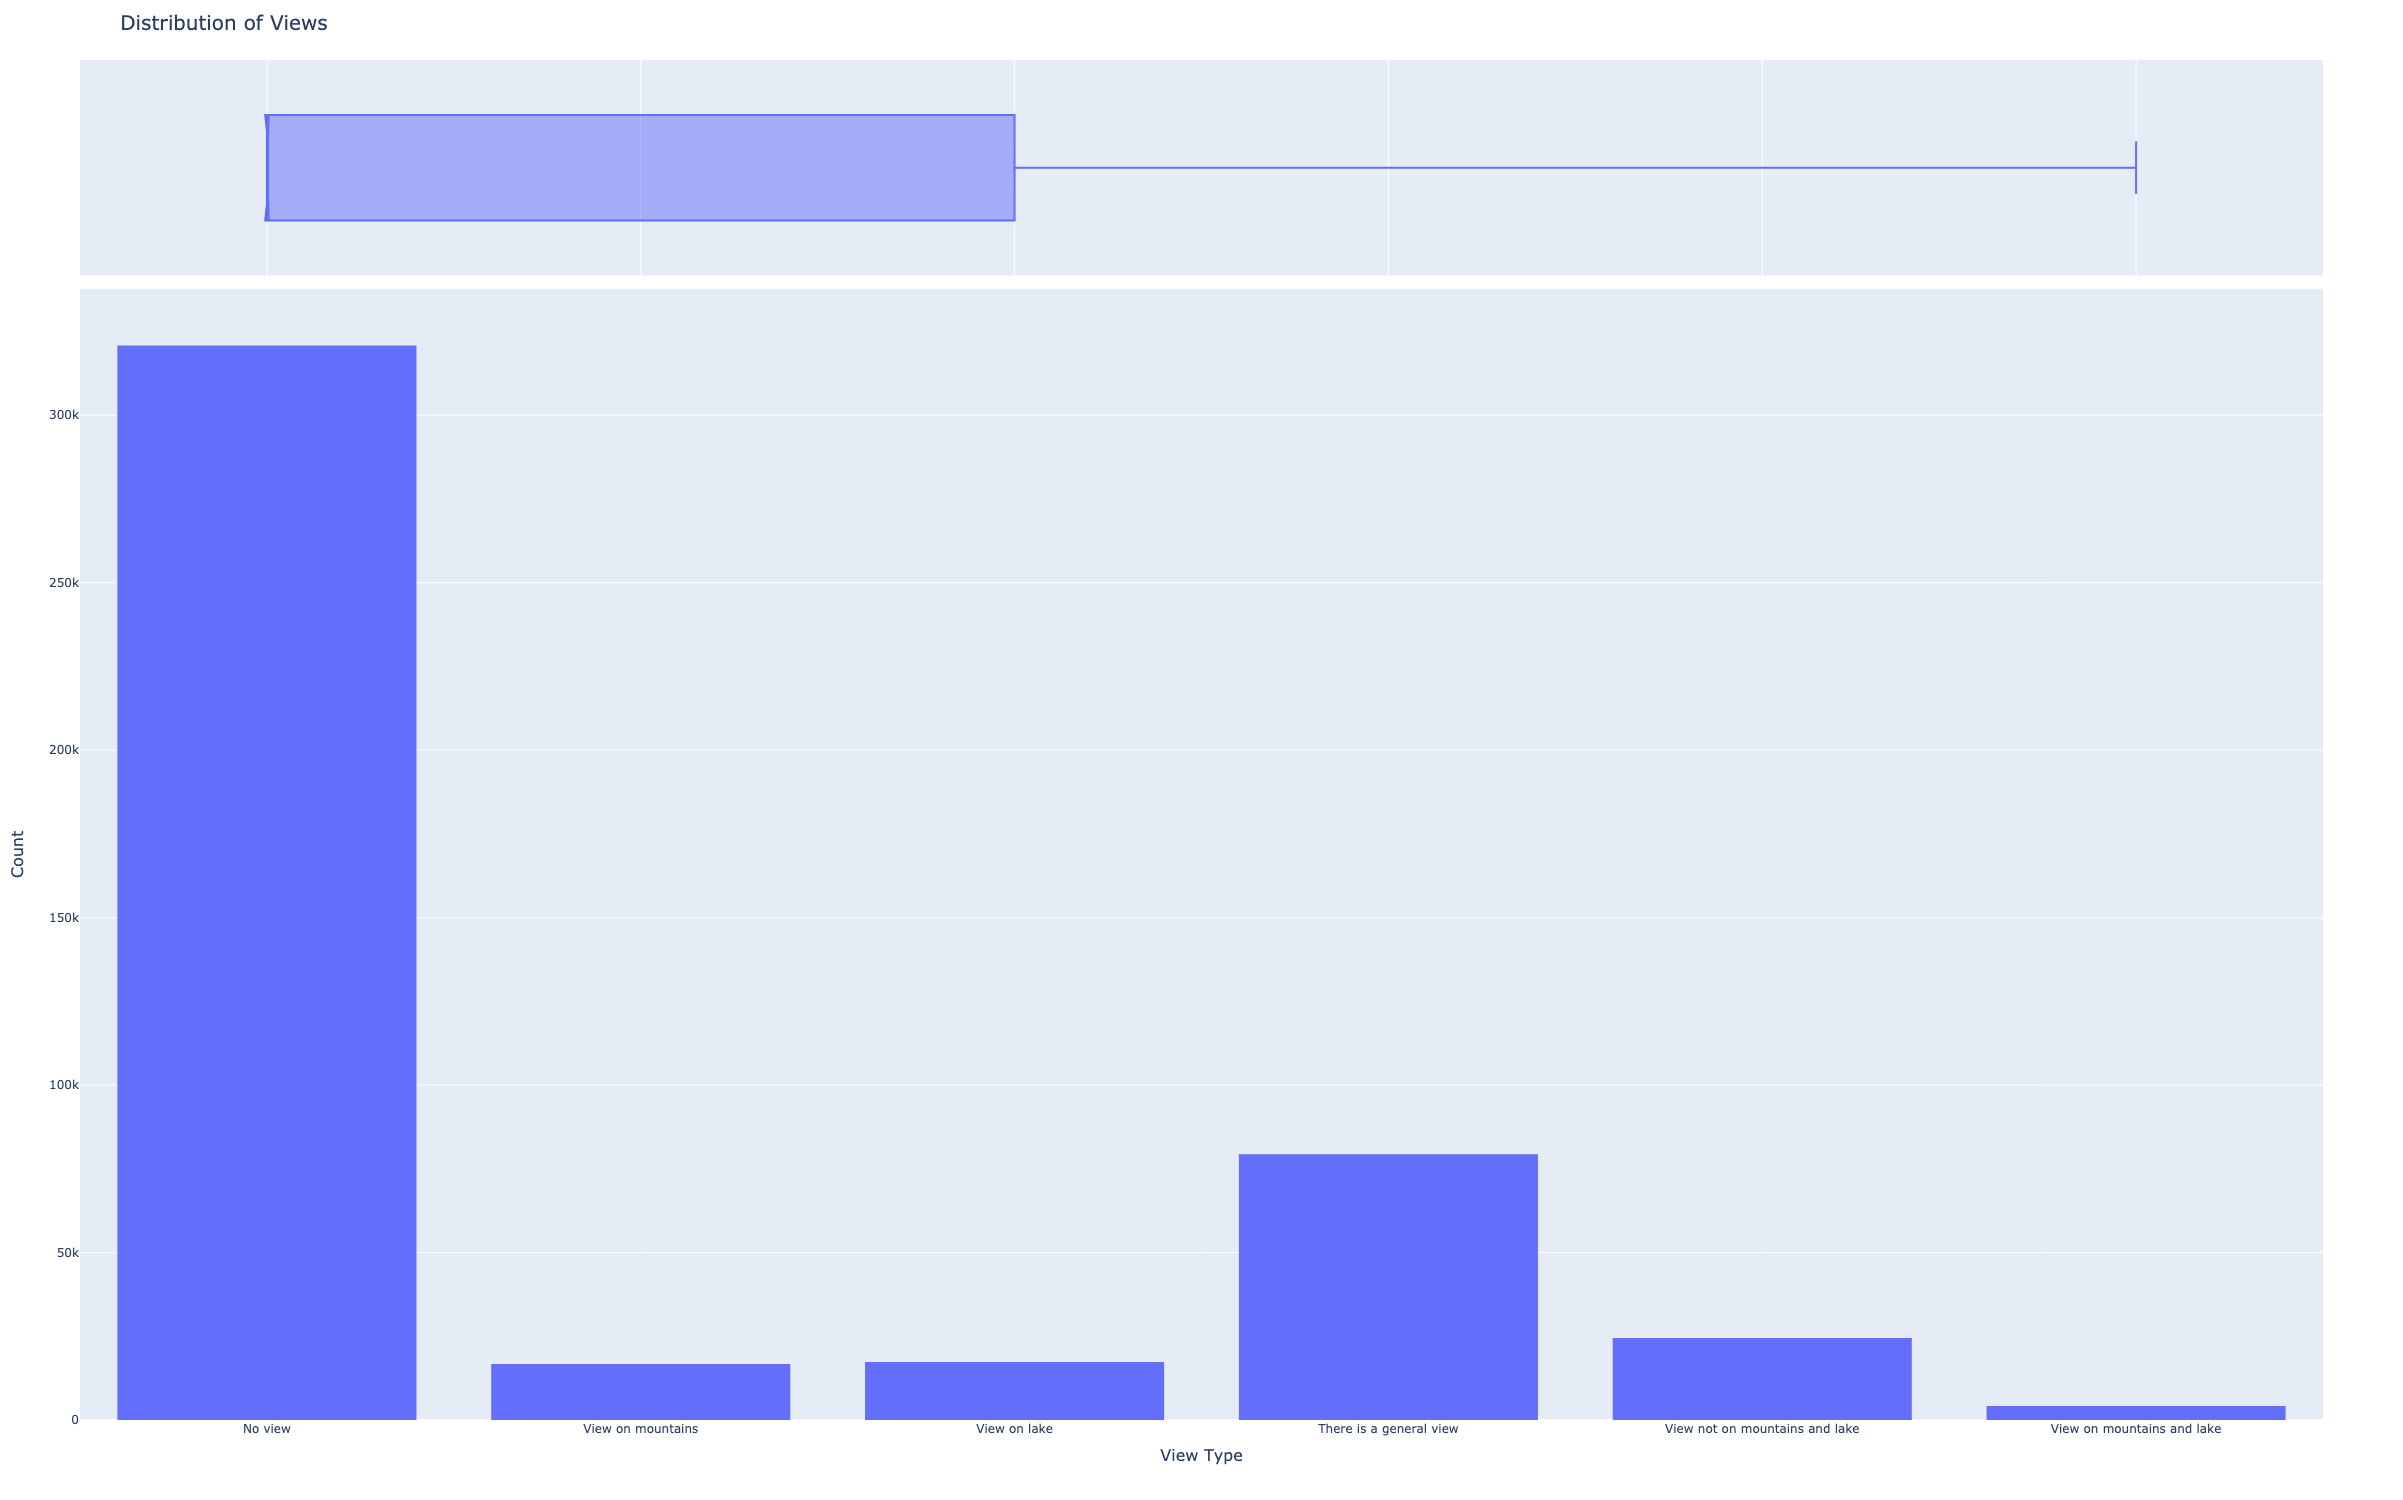

In [30]:
# Map view codes to labels
view_labels = {
    0: "No view",
    1: "There is a general view",
    2: "View on mountains",
    3: "View on lake",
    4: "View on mountains and lake",
    5: "View not on mountains and lake"
}
df["view_label"] = df["a_sicht"].map(view_labels)


fig = px.histogram(df, x="view_label", marginal="box")
width_inches = 8.01
height_inches = 5

#Annotations
fig.update_layout(
    legend=dict(font=dict(size=16)),
    title=dict(text="Distribution of Views", font=dict(size=20)),
    xaxis=dict(title=dict(text="View Type", font=dict(size=16))),
    yaxis=dict(title=dict(text="Count", font=dict(size=16))),
)

dpi = 300

# Save the figure as a PNG image
pio.write_image(fig, "fig_9.png", width=int(width_inches * dpi), height=int(height_inches * dpi))

# Display the saved image in the notebook
Image(filename="fig_9.png")

#To view interactive plot in JupyterNotebook, uncomment the next line.
#fig.show()


In [31]:
df.to_csv("step_2_bm.csv")

**Mahala Nobis distance**


Before the Mahala Nobis distance method was applied to the data, several regressions were conducted on the data. The model performed very poorly with RSME values above 2000, and all assumptions of linear regressions were completly violated. Thus a rather strict significance level of 0.05% was applied leading to a threshold of 95 (chi-squared distribution). Through tedious visual case-by-case inspection of high rents dwellings, most were found to be erroneous. The data is thus biased towards low to medium-high rents but has no rents above 3800, as otherwise, the RSME and linear regression assumptions were violated entirely, and it was difficult to draw significant insights from the data. The Mahala Nobis distance method was performed on the data as some outliers may not seem apparent when observed only in relation to one other variable; however, they do when looking at four simultaneously. The four most significant variables were taken: Rents, Living surface, age of the building and location. The basic concept of this method is to analyze the distance of the observation from the central tendency and the covariance between the variables. (Ghorbani, 2019) First we visualize the chosen threshold.

We perform the outlier removal process.

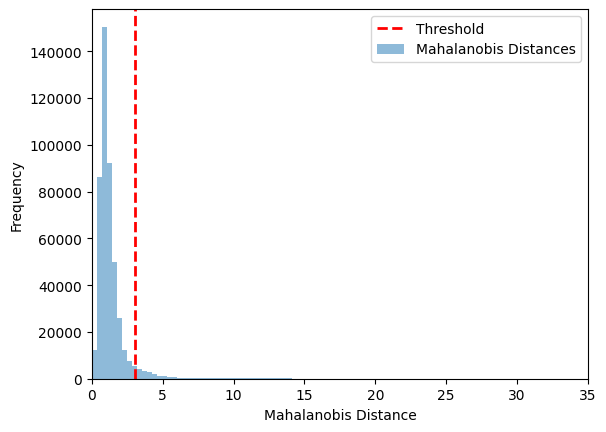

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist

variables = ['a_netm_mon', 'a_surface_living', 'age']
data = df[variables]
mean = data.mean()
covariance = data.cov()

distances = []
for index, row in data.iterrows():
    distance = dist.mahalanobis(row, mean, np.linalg.inv(covariance))
    distances.append(distance)

threshold = np.percentile(distances, 95)

bins = np.linspace(0, 35, 100)
plt.hist(distances, bins=bins, alpha=0.5)

plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)


plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.legend(['Threshold', 'Mahalanobis Distances'])
plt.xlim(0, 35)


plt.show()


In [33]:
dfb=df
# Select variables for testing multivariate outliers
variables = ['a_netm_mon', 'a_surface_living', 'age']
data = df[variables]

# Calculate the mean and covariance matrix of the data
mean = data.mean()
covariance = data.cov()

# Calculate the distances
distances = []
for index, row in data.iterrows():
    distance = dist.mahalanobis(row, mean, np.linalg.inv(covariance))
    distances.append(distance)

# Define the threshold 
threshold = np.percentile(distances, 95)

outliers = []
for i, distance in enumerate(distances):
    if distance > threshold:
        outliers.append(i)

significance_level = 0.05
expected_false_positives = int(significance_level * len(distances))
df_cleaned = df.drop(df.index[outliers])


print('Number of outliers removed:', len(outliers))

df = df_cleaned

Number of outliers removed: 23139


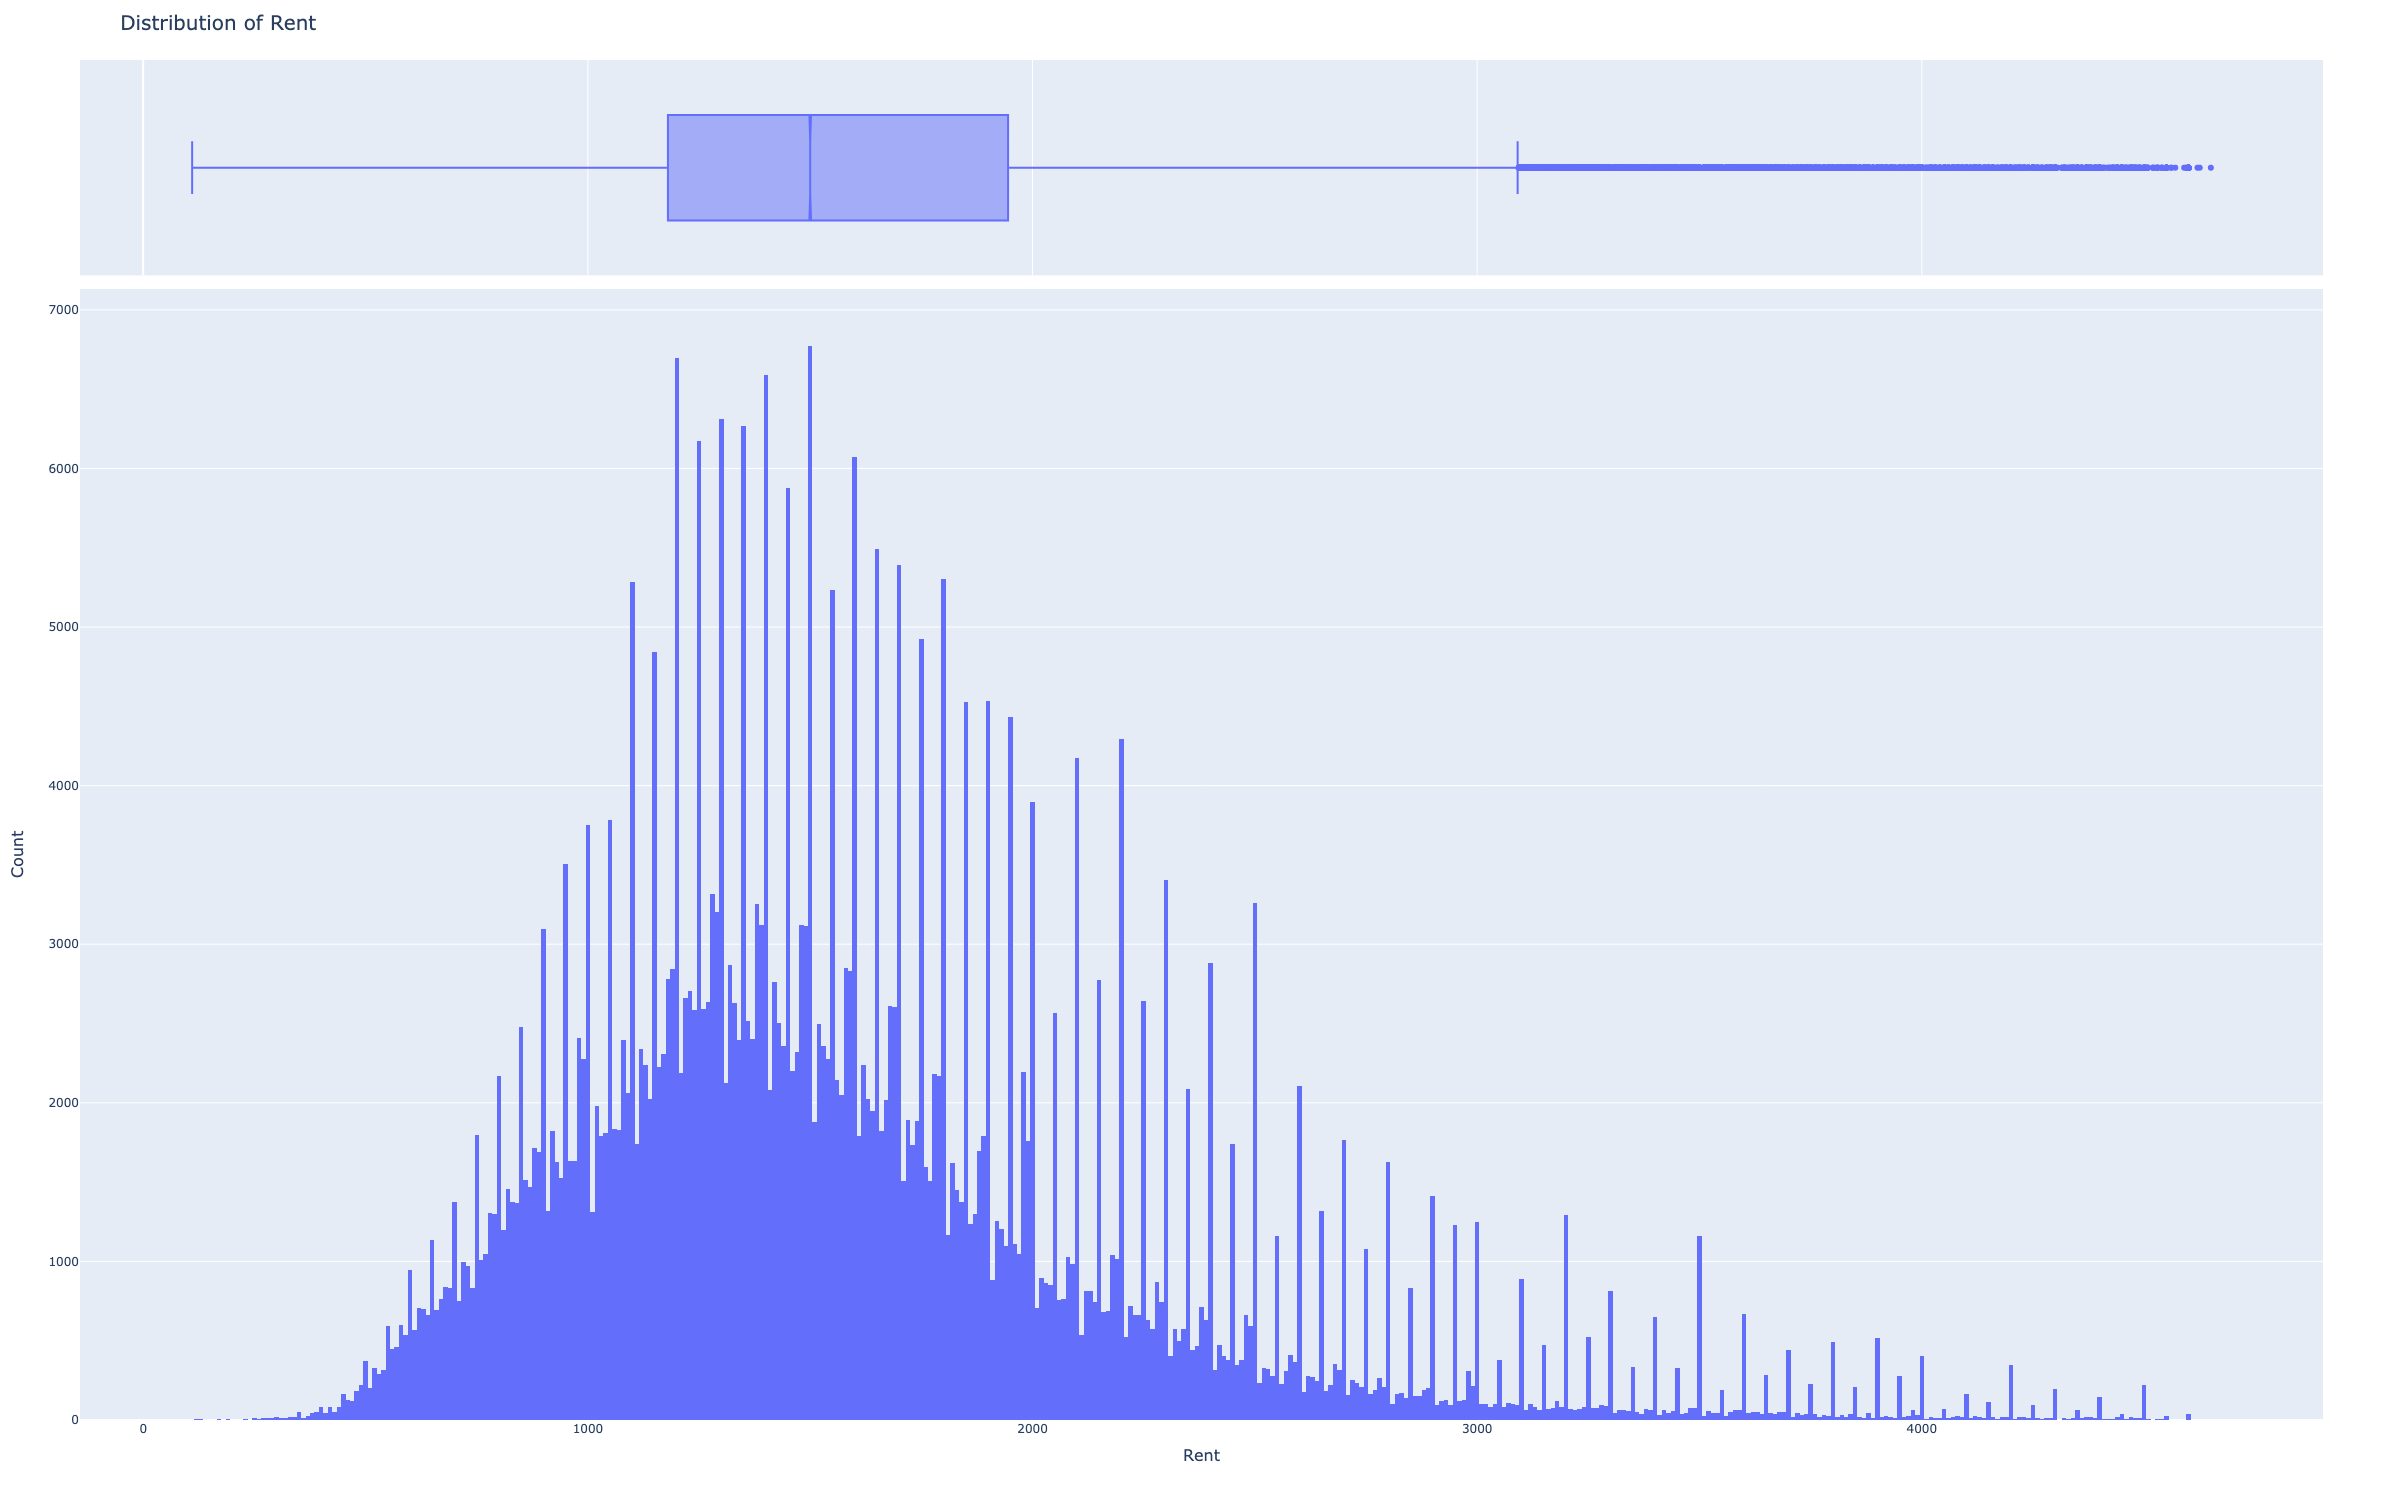

In [34]:
#Figure 10
fig = px.histogram(df, x="a_netm_mon", marginal="box")

# Dimensions
width_inches = 8.01
height_inches = 5

#Annotations
fig.update_layout(
    legend=dict(font=dict(size=16)),
    title=dict(text="Distribution of Rent", font=dict(size=20)),
    xaxis=dict(title=dict(text="Rent", font=dict(size=16))),
    yaxis=dict(title=dict(text="Count", font=dict(size=16))),
)

# DPI for printing
dpi = 300

# Save the figure as a PNG image
pio.write_image(fig, "fig_10.png", width=int(width_inches * dpi), height=int(height_inches * dpi))

# Display the saved image in the notebook
Image(filename="fig_10.png")

#To view interactive plot in JupyterNotebook, uncomment the next line.
#fig.show()

A few simple regressions are performed on data before and after the transformation to evaluate the effect of the outlier removal.

#### Regression before Mahalanobis


In [35]:
dfb.head

<bound method NDFrame.head of          a_zip_2 a_kat_o_2  a_surface_living  a_netm_mon  a_nb_rooms  a_sicht  \
2           4123        AP              85.0      1665.0         3.5        0   
6           8863        AP              83.0      1540.0         4.0        2   
8           3095        AP              83.0      1100.0         3.0        0   
12          8052        HO              98.0      2250.0         5.0        0   
14          3186        AP             110.0      1500.0         4.5        0   
...          ...       ...               ...         ...         ...      ...   
1420565     4123        AP             103.0      2120.0         4.5        0   
1420570     7430        AP              77.0      1200.0         3.5        0   
1420571     7500        AP             135.0      2480.0         5.5        0   
1420572     5074        AP              81.0      1410.0         2.5        0   
1420573     7302        AP              95.0      1680.0         2.5        0  

In [36]:
X_before = dfb[["a_surface_living", "age", "a_zip_2"]]
y_before = dfb["a_netm_mon"] 

# Add a constant term to the predictor variables
X_before = sm.add_constant(X_before)

# Fit the linear regression model
model_befor_1 = sm.OLS(y_before, X_before).fit()

# Print the summary of the linear regression model
print(model_before.summary())
print(f"AIC: {model_befor_1.aic}")

                            OLS Regression Results                            
Dep. Variable:             a_netm_mon   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                 2.538e+05
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        11:19:57   Log-Likelihood:            -4.9878e+06
No. Observations:              631258   AIC:                         9.976e+06
Df Residuals:                  631254   BIC:                         9.976e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              307.4707     24.685  

#### Regression before Mahalanobis and with variable transformation

In [37]:
X_before = dfb[["a_surface_living", "age", "a_zip_2"]]
# Log the surface variable
X_before.loc[:,'a_surface_living'] = np.log(X_before['a_surface_living'])
# Square the age variable
X_before.loc[:,'age'] = X_before['age']**2

y_before = dfb["a_netm_mon"]

# Add a constant term to the predictor variables
X_before = sm.add_constant(X_before)

# Fit the linear regression model
model_before_2 = sm.OLS(y_before, X_before).fit()

# Print the summary of the linear regression model
print(model_before_2.summary())
print(f"AIC: {model_before_2.aic}")

                            OLS Regression Results                            
Dep. Variable:             a_netm_mon   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                 1.215e+05
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        11:19:57   Log-Likelihood:            -3.7042e+06
No. Observations:              462780   AIC:                         7.408e+06
Df Residuals:                  462776   BIC:                         7.408e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -5265.3087     11.773  

#### Regression after Mahalanobis

In [38]:
X_before = df[["a_surface_living", "age", "a_zip_2"]]
y_before = df["a_netm_mon"] 

# Add a constant term to the predictor variables
X_before = sm.add_constant(X_before)

# Fit the linear regression model
model_after_1 = sm.OLS(y_before, X_before).fit()

# Print the summary of the linear regression model
print(model_before.summary())
print(f"AIC: {model_after_1.aic}")

                            OLS Regression Results                            
Dep. Variable:             a_netm_mon   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                 2.538e+05
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        11:19:57   Log-Likelihood:            -4.9878e+06
No. Observations:              631258   AIC:                         9.976e+06
Df Residuals:                  631254   BIC:                         9.976e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              307.4707     24.685  

#### Regression after Mahalanobis and with variable transformation

In [39]:
X_before = df[["a_surface_living", "age", "a_zip_2"]]
# Log the surface variable
X_before.loc[:,'a_surface_living'] = np.log(X_before['a_surface_living'])
# Square the age variable
X_before.loc[:,'age'] = X_before['age']**2

y_before = df["a_netm_mon"]

# Add a constant term to the predictor variables
X_before = sm.add_constant(X_before)

# Fit the linear regression model
model_after_2 = sm.OLS(y_before, X_before).fit()

# Print the summary of the linear regression model
print(model_before_2.summary())
print(f"AIC: {model_after_2.aic}")

                            OLS Regression Results                            
Dep. Variable:             a_netm_mon   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                 1.215e+05
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        11:19:58   Log-Likelihood:            -3.7042e+06
No. Observations:              462780   AIC:                         7.408e+06
Df Residuals:                  462776   BIC:                         7.408e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -5265.3087     11.773  

The same simple regression improved the adjusted R. Moreover, before this procedure, transforming the living surface as a log did not improve the model, which goes against classical theory on real estate prefferences. After this procedure, transforming the living surface into a log improved the model. The same result is observed for the age of the building when squaring it. This is interesting as it shows that common behaviour of data found in other studies is now present in the dataset, thus suggesting many mistakes were removed. The common behavior include but are not limited to decreasing marginal willigness to par for larger spaces, and more heavily penalized extreme values for the age variable.

Lastle, the variables distributions are observed once again after the outlier detection process is finished. Modify the variable names to see the different distributions.

In [40]:
"""df = pd.read_csv('rents_S3_Done.csv', nrows=100000)
fig = px.histogram(df, x="a_nb_rooms", marginal="box")

# Dimensions
width_inches = 8.01
height_inches = 5

#Annotations
fig.update_layout(
    legend=dict(font=dict(size=16)),
    title=dict(text="Distribution of number of rooms", font=dict(size=20)),
    xaxis=dict(title=dict(text="Number of rooms", font=dict(size=16))),
    yaxis=dict(title=dict(text="Count", font=dict(size=16))),
)

# DPI for printing
dpi = 300

# Save the figure as a PNG image
pio.write_image(fig, "fig_500.png", width=int(width_inches * dpi), height=int(height_inches * dpi))

# Display the saved image in the notebook
#Image(filename="fig_100.png")

#To view interactive plot in JupyterNotebook, uncomment the next line.
fig.show()"""

'df = pd.read_csv(\'rents_S3_Done.csv\', nrows=100000)\nfig = px.histogram(df, x="a_nb_rooms", marginal="box")\n\n# Dimensions\nwidth_inches = 8.01\nheight_inches = 5\n\n#Annotations\nfig.update_layout(\n    legend=dict(font=dict(size=16)),\n    title=dict(text="Distribution of number of rooms", font=dict(size=20)),\n    xaxis=dict(title=dict(text="Number of rooms", font=dict(size=16))),\n    yaxis=dict(title=dict(text="Count", font=dict(size=16))),\n)\n\n# DPI for printing\ndpi = 300\n\n# Save the figure as a PNG image\npio.write_image(fig, "fig_500.png", width=int(width_inches * dpi), height=int(height_inches * dpi))\n\n# Display the saved image in the notebook\n#Image(filename="fig_100.png")\n\n#To view interactive plot in JupyterNotebook, uncomment the next line.\nfig.show()'

### New Variables



The raw data included the coordinates of each listing. In order to classify each observation to one of the three Swiss regions a K Neirest Neighbor algorith was performed on the data. This algorith sets different points \(refference points\) each beloning to a class. The refference points were defined mannualy, visisble in figure 10.


In [41]:
#Figure 10

#Interactive map code --
column_names = ["STATION NAME", "longitude2", "latitude2"]


German = [
("Zurich",8.5391825,47.3686498),#0
("St. Gallen",9.3787173,47.4244818),#1
("Bern",7.4474,46.9480),#2
("Munsingen",7.5628,46.8747),#3
("Thun",7.6280,467580),#4
("Frutigen",7.6469,46.5898),#5
("Wattenwill",7.5098,46.7699),#6
("Wimmis",7.6386,46.6761),#7
("Interlaken",7.8632,46.6863),#8
("Leuk",7.6346,46.3169),#9
("Leukerbad",7.6288,46.3800),#10
("St-niklaus",7.8046,46.1762),#11
("Zermatt",7.4455,46.0111),#12
("Lucerne",8.3093,47.0502),#13
("Bale",7.5886,47.5596),#14
("Coire",9.5320,46.8508),#15
("Aldorf",8.6428,46.8821),#16
("wassen",8.5999,46.7070),#17
("Ilanz",9.2047,46.7742),#18
("Splugen",9.3210,46.5491),#19
("Brig",7.9878,46.3159)#20
    
]
French = [
("Geneva",6.153438,46.201664),#21
("Montreux",6.9106799,46.4312213),#22
("Lausanne",6.6322734,46.5196535),#23
("Aigle",6.9667,46.3167),#24
("Bulle",7.0577268,46.6154512),#24
("Yverdons",6.641183,46.7784736),#25
("Neuchatel",6.931933,46.992979),#26
("La Chaux-de-Fonds",6.8328,47.1035),#27
("Orsières",7.1471,46.0282),#28
("Saignelégier",6.9964,47.2562),#29
("Bassecourt",7.2427,47.3389),#30
("Paverne",6.9406,46.8220)#31
]

Italian = [
("Lugano",8.952130,46.004644),#32
("Locarno",8.795714,46.168683),#33
("Fusio",8.6500,46.4333),#34
("Faido",8.8010,46.4782),#35
("Acquarossa",8.9398,46.4546),#36
("Biasca",8.9705,46.3580),#37
("Cevio",8.6023,46.3177),#38
("Bellinzona",9.0244,46.1946)#39
]


import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

m = folium.Map([46.8, 8.33], zoom_start=5)



French = pd.DataFrame(French, columns = column_names)
German = pd.DataFrame(German, columns = column_names)
Italian = pd.DataFrame(Italian, columns = column_names)

#French_transac = pd.read_csv("fre_rent.csv") 
#Italian_transac = pd.read_csv("ita_rent.csv") 
#German_transac = pd.read_csv("ger_rent.csv")



#The K cities
for index, row in French.iterrows():
   folium.CircleMarker([row['latitude2'],row['longitude2']],
                    radius=7,
                    #popup=row['Density'],
                    fill_color="blue", # divvy color
                    fill_opacity=0.5,
                    color = 'blue'
                   ).add_to(m)

for index, row in German.iterrows():
   folium.CircleMarker([row['latitude2'],row['longitude2']],
                    radius=7,
                    #popup=row['Density'],
                    fill_color="green", # divvy color
                    fill_opacity=0.5,
                    color = 'green',
                   ).add_to(m)

for index, row in Italian.iterrows():
   folium.CircleMarker([row['latitude2'],row['longitude2']],
                    radius=7,
                    #popup=row['Density'],
                    fill_color="red", # divvy color
                    fill_opacity=0.5,
                    color = 'red',
                   ).add_to(m)
#Uncomment to see 
#m

#Image map code --

#image = mpimg.imread("map_1.png")
#plt.figure(figsize=(20, 20))
#plt.axis('off')

# Display image
#plt.imshow(image)
#plt.show()

This algorithm is largely based on [the works of Corey Hanson](<https://towardsdatascience.com/using-scikit-learns-binary-trees-to-efficiently-find-latitude-and-longitude-neighbors-909979bd >) using sk\-learn library. (Hanson, 2020)

First a list of cities is defined with their corresponding names, longitude, and latitude values, and converts it into a DataFrame named cities. The KDTree object named kd uses the longitude and latitude values of the cities to find the nearest city for each data point in the points DataFrame using the KDTree object and the query() method


It finds the nearest city for each data point in the points DataFrame using the KDTree object and the query() method. The nearest city indices and distances are stored in indices and distances variables, respectively. Then based on the number assigned to the city, the observations are categorised in the different regions.


In [42]:
points = pd.read_csv("Rent_S2_Done.csv")
points_orig = pd.read_csv("Rent_S2_Done.csv")

# ------- start of the KNN
column_names = ["STATION NAME", "longitude2", "latitude2"]


cities = [
    ("Zurich", 8.5391825, 47.3686498),  # 0
    ("St. Gallen", 9.3787173, 47.4244818),  # 1
    ("Bern", 7.4474, 46.9480),  # 2
    ("Munsingen", 7.5628, 46.8747),  # 3
    ("Thun", 7.6280, 467580),  # 4
    ("Frutigen", 7.6469, 46.5898),  # 5
    ("Wattenwill", 7.5098, 46.7699),  # 6
    ("Wimmis", 7.6386, 46.6761),  # 7
    ("Interlaken", 7.8632, 46.6863),  # 8
    ("Leuk", 7.6346, 46.3169),  # 9
    ("Leukerbad", 7.6288, 46.3800),  # 10
    ("St-niklaus", 7.8046, 46.1762),  # 11
    ("Zermatt", 7.4455, 46.0111),  # 12
    ("Lucerne", 8.3093, 47.0502),  # 13
    ("Bale", 7.5886, 47.5596),  # 14
    ("Coire", 9.5320, 46.8508),  # 15
    ("Aldorf", 8.6428, 46.8821),  # 16
    ("wassen", 8.5999, 46.7070),  # 17
    ("Ilanz", 9.2047, 46.7742),  # 18
    ("Splugen", 9.3210, 46.5491),  # 19
    ("Brig", 7.9878, 46.3159),  # 20
    ("Geneva", 6.153438, 46.201664),  # 21
    ("Montreux", 6.9106799, 46.4312213),  # 22
    ("Lausanne", 6.6322734, 46.5196535),  # 23
    ("Aigle", 6.9667, 46.3167),  # 24
    ("Bulle", 7.0577268, 46.6154512),  # 24
    ("Yverdons", 6.641183, 46.7784736),  # 25
    ("Neuchatel", 6.931933, 46.992979),  # 26
    ("La Chaux-de-Fonds", 6.8328, 47.1035),  # 27
    ("Orsières", 7.1471, 46.0282),  # 28
    ("Saignelégier", 6.9964, 47.2562),  # 29
    ("Bassecourt", 7.2427, 47.3389),  # 30
    ("Paverne", 6.9406, 46.8220),  # 31
    ("Lugano", 8.952130, 46.004644),  # 32
    ("Locarno", 8.795714, 46.168683),  # 33
    ("Fusio", 8.6500, 46.4333),  # 34
    ("Faido", 8.8010, 46.4782),  # 35
    ("Acquarossa", 8.9398, 46.4546),  # 36
    ("Biasca", 8.9705, 46.3580),  # 37
    ("Cevio", 8.6023, 46.3177),  # 38
    ("Bellinzona", 9.0244, 46.1946),  # 39
]
cities = pd.DataFrame(cities, columns=column_names)
# points = pd.DataFrame(points, columns = column_names)

kd = KDTree(cities[["longitude2", "latitude2"]].values, metric="euclidean")
k = 1
distances, indices = kd.query(points[["longitude2", "latitude2"]], k=k)

s = pd.Series([distances, indices])
# s.to_csv("s.csv")

points_categorised = pd.DataFrame(points_orig)
points_categorised_2 = points_categorised.assign(region=indices)
points_categorised_2.to_csv("trash.csv")
# Replacing the numbers with the name of the region

# Seperating the different regions in three different datasets

ger = pd.read_csv("trash.csv")
ger.drop(ger[ger["region"] > 20].index, inplace=True)
# ger.to_csv("ger_rent.csv")


fre = pd.read_csv("trash.csv")
fre.drop(fre[fre["region"] <= 20].index, inplace=True)
fre.drop(fre[fre["region"] > 31].index, inplace=True)
# fre.to_csv("fre_rent.csv")

ita = pd.read_csv("trash.csv")
ita.drop(ita[ita["region"] < 32].index, inplace=True)
# ita.to_csv("ita_rent.csv")


ger.region = 0
fre.region = 1
ita.region = 2
frames = [ger, fre, ita]


result = pd.concat(frames)
result = result.drop("Unnamed: 0", axis=1)
result = result.drop("Unnamed: 0.1", axis=1)

